In [1]:
# import module
import random
import numpy as np
from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

# make game
env = gym.make('CartPole-v1')

# seed the experiment
env.seed(9)
np.random.seed(9)
random.seed(9) 
torch.manual_seed(9)

/Users/Kevin/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# define our policy
class DQN(nn.Module):
    def __init__(self, observation_space, action_space):
        super(DQN, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.fc1 = nn.Linear(self.observation_space, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, self.action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# define our agent
class Agent:
    def __init__(self, policy_net, target_net):
        MEMORY_SIZE = 10000
        GAMMA = 0.6
        BATCH_SIZE = 128
        EXPLORATION_MAX = 0.9
        EXPLORATION_MIN = 0.05
        EXPLORATION_DECAY = 0.95
        # 1, 2, 3 
        TARGET_UPDATE = 1

        self.policy_net = policy_net
        self.target_net = target_net
        self.target_net.load_state_dict(policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-3)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        self.exploration_rate = EXPLORATION_MAX
        self.exploration_min = EXPLORATION_MIN
        self.exploration_decay = EXPLORATION_DECAY
        self.target_update = TARGET_UPDATE
    
    def select_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return torch.tensor([[random.randrange(self.policy_net.action_space)]])
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.max(1)[1].view(1,1)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def update_target_net(self, i_episode):
        if i_episode % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        # fetch data
        print("[ Experience replay ] starts")
        batch = random.sample(self.memory, self.batch_size)
        batch_state = torch.cat(tuple([x[0] for x in batch]))
        batch_action = torch.cat(tuple([x[1] for x in batch]))
        batch_reward = torch.cat(tuple([x[2] for x in batch]))
        batch_next_state = [x[3] for x in batch]
        non_final_next_states = torch.cat(tuple([s for s in batch_next_state if s is not None]))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), dtype=torch.bool)
        
        # policy net forward pass to get Q values
        state_action_values = self.policy_net(batch_state).gather(1, batch_action)
        # target net forward pass to get Q values of next state
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma).unsqueeze(1) + batch_reward

        # train policy
        policy_loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        policy_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # the more policy gets replayed, the less the agent explores
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)

In [3]:
# create policy
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
policy_net = DQN(observation_space, action_space)
target_net = DQN(observation_space, action_space)

# create agent
agent = Agent(policy_net, target_net)

# play game
game_durations = []
for i_episode in count(1):
    state = env.reset()
    state = torch.tensor([state]).float()
    print("[ episode {} ] state={}".format(i_episode, state))
    for t in range(1, 10000):
        action = agent.select_action(state)
        state_next, reward, done, _ = env.step(action.item())
        if done:
            state_next = None
        else:
            state_next = torch.tensor([state_next]).float()
        agent.remember(state, action, torch.tensor([[reward]]).float(), state_next)
        print("[ episode {} ][ timestamp {} ] state={}, action={}, reward={}, next_state={}".format(i_episode, t, state, action, reward, state_next))
        state = state_next
        agent.experience_replay()
        if done:
            game_durations.append(t)
            break
    print("[ Ended! ] Episode {}: Exploration_rate={}. Score={}.".format(i_episode, agent.exploration_rate, t))
    # Update the target network, copying all weights and biases in DQN
    agent.update_target_net(i_episode)

    # end game criteria
    if t > env.spec.reward_threshold:
        print("[ Solved! ] Score is now {}".format(t))
        break
    elif i_episode > 500:
        print("[ Failed! ] took more than 500 episodes")
        break


[ episode 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]])
[ episode 1 ][ timestamp 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]])
[ episode 1 ][ timestamp 2 ] state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]])
[ episode 1 ][ timestamp 3 ] state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]])
[ episode 1 ][ timestamp 4 ] state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]])
[ episode 1 ][ timestamp 5 ] state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0278,  0.2163, -0.0350, -0.2700]])
[ episode 1 ][ timestamp 6 ] state=tensor([[ 0.0278,  0.21

[ episode 8 ][ timestamp 10 ] state=tensor([[-2.7817e-04,  2.0024e-01, -1.2311e-02, -2.9721e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0037,  0.0053, -0.0183, -0.0084]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 11 ] state=tensor([[ 0.0037,  0.0053, -0.0183, -0.0084]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0038,  0.2007, -0.0184, -0.3068]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 12 ] state=tensor([[ 0.0038,  0.2007, -0.0184, -0.3068]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0078,  0.0058, -0.0246, -0.0200]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 13 ] state=tensor([[ 0.0078,  0.0058, -0.0246, -0.0200]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0080,  0.2013, -0.0250, -0.3203]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 14 ] state=tensor([[ 0.0080,  0.2013, -0.0250, -0.3203]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0120,  0.0065, -0.0314,

[ episode 13 ][ timestamp 10 ] state=tensor([[ 0.1291,  1.0192, -0.1675, -1.6261]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1495,  1.2158, -0.2000, -1.9660]])
[ Experience replay ] starts
[ episode 13 ][ timestamp 11 ] state=tensor([[ 0.1495,  1.2158, -0.2000, -1.9660]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 13: Exploration_rate=0.05. Score=11.
[ episode 14 ] state=tensor([[-0.0375, -0.0062, -0.0041, -0.0405]])
[ episode 14 ][ timestamp 1 ] state=tensor([[-0.0375, -0.0062, -0.0041, -0.0405]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0376,  0.1889, -0.0049, -0.3345]])
[ Experience replay ] starts
[ episode 14 ][ timestamp 2 ] state=tensor([[-0.0376,  0.1889, -0.0049, -0.3345]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0339,  0.3841, -0.0116, -0.6287]])
[ Experience replay ] starts
[ episode 14 ][ timestamp 3 ] state=tensor([[-0.0339,  0.3841, -0.0116, -0.6287]]), action=tenso

[ episode 18 ][ timestamp 12 ] state=tensor([[ 0.0669,  0.6270, -0.1719, -1.1492]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0794,  0.4345, -0.1949, -0.9150]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 13 ] state=tensor([[ 0.0794,  0.4345, -0.1949, -0.9150]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 18: Exploration_rate=0.05. Score=13.
[ episode 19 ] state=tensor([[0.0339, 0.0257, 0.0215, 0.0011]])
[ episode 19 ][ timestamp 1 ] state=tensor([[0.0339, 0.0257, 0.0215, 0.0011]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0344,  0.2205,  0.0215, -0.2847]])
[ Experience replay ] starts
[ episode 19 ][ timestamp 2 ] state=tensor([[ 0.0344,  0.2205,  0.0215, -0.2847]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0388,  0.4153,  0.0158, -0.5705]])
[ Experience replay ] starts
[ episode 19 ][ timestamp 3 ] state=tensor([[ 0.0388,  0.4153,  0.0158, -0.5705]]), action=tensor([[1]])

[ episode 24 ][ timestamp 8 ] state=tensor([[ 0.0380,  0.5638, -0.0070, -0.7794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0493,  0.3688, -0.0226, -0.4889]])
[ Experience replay ] starts
[ episode 24 ][ timestamp 9 ] state=tensor([[ 0.0493,  0.3688, -0.0226, -0.4889]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0567,  0.5642, -0.0324, -0.7886]])
[ Experience replay ] starts
[ episode 24 ][ timestamp 10 ] state=tensor([[ 0.0567,  0.5642, -0.0324, -0.7886]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0680,  0.3695, -0.0481, -0.5063]])
[ Experience replay ] starts
[ episode 24 ][ timestamp 11 ] state=tensor([[ 0.0680,  0.3695, -0.0481, -0.5063]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0754,  0.5653, -0.0583, -0.8137]])
[ Experience replay ] starts
[ episode 24 ][ timestamp 12 ] state=tensor([[ 0.0754,  0.5653, -0.0583, -0.8137]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0867,  0.3710, -0.0745, -0.5399]])
[

[ Ended! ] Episode 26: Exploration_rate=0.05. Score=18.
[ episode 27 ] state=tensor([[ 0.0076, -0.0180,  0.0341,  0.0072]])
[ episode 27 ][ timestamp 1 ] state=tensor([[ 0.0076, -0.0180,  0.0341,  0.0072]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0073,  0.1766,  0.0342, -0.2745]])
[ Experience replay ] starts
[ episode 27 ][ timestamp 2 ] state=tensor([[ 0.0073,  0.1766,  0.0342, -0.2745]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0108,  0.3712,  0.0287, -0.5562]])
[ Experience replay ] starts
[ episode 27 ][ timestamp 3 ] state=tensor([[ 0.0108,  0.3712,  0.0287, -0.5562]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0182,  0.5659,  0.0176, -0.8397]])
[ Experience replay ] starts
[ episode 27 ][ timestamp 4 ] state=tensor([[ 0.0182,  0.5659,  0.0176, -0.8397]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0295,  0.3706,  0.0008, -0.5415]])
[ Experience replay ] starts
[ episode 27 ][ timestamp 5 ] state=tensor([[ 0.0295,  0

[ episode 29 ][ timestamp 22 ] state=tensor([[ 0.1515,  0.2306, -0.2026, -0.6315]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 29: Exploration_rate=0.05. Score=22.
[ episode 30 ] state=tensor([[-0.0125, -0.0010, -0.0431,  0.0157]])
[ episode 30 ][ timestamp 1 ] state=tensor([[-0.0125, -0.0010, -0.0431,  0.0157]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0125,  0.1947, -0.0428, -0.2902]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 2 ] state=tensor([[-0.0125,  0.1947, -0.0428, -0.2902]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0086,  0.3904, -0.0486, -0.5961]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 3 ] state=tensor([[-0.0086,  0.3904, -0.0486, -0.5961]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0008,  0.1960, -0.0605, -0.3191]])
[ Experience replay ] starts
[ episode 30 ][ timestamp 4 ] state=tensor([[-0.0008,  0.1960, -0.0605, -0.3191]]), action=tensor

[ episode 34 ][ timestamp 2 ] state=tensor([[ 0.0039, -0.1756, -0.0141,  0.3170]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0003,  0.0197, -0.0078,  0.0199]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 3 ] state=tensor([[ 0.0003,  0.0197, -0.0078,  0.0199]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0007,  0.2149, -0.0074, -0.2753]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 4 ] state=tensor([[ 0.0007,  0.2149, -0.0074, -0.2753]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0050,  0.4102, -0.0129, -0.5703]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 5 ] state=tensor([[ 0.0050,  0.4102, -0.0129, -0.5703]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0132,  0.2152, -0.0243, -0.2817]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 6 ] state=tensor([[ 0.0132,  0.2152, -0.0243, -0.2817]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0175,  0.0204, -0.0299,  0.0032]])
[ Ex

[ episode 35 ][ timestamp 22 ] state=tensor([[ 0.1949,  0.2517, -0.1649, -0.5704]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1999,  0.0593, -0.1763, -0.3338]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 23 ] state=tensor([[ 0.1999,  0.0593, -0.1763, -0.3338]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.2011,  0.2564, -0.1830, -0.6765]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 24 ] state=tensor([[ 0.2011,  0.2564, -0.1830, -0.6765]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2062,  0.0642, -0.1965, -0.4466]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 25 ] state=tensor([[ 0.2062,  0.0642, -0.1965, -0.4466]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.2075,  0.2615, -0.2054, -0.7942]])
[ Experience replay ] starts
[ episode 35 ][ timestamp 26 ] state=tensor([[ 0.2075,  0.2615, -0.2054, -0.7942]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 39 ][ timestamp 5 ] state=tensor([[ 0.0227,  0.3639, -0.0259, -0.6281]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0300,  0.1691, -0.0385, -0.3437]])
[ Experience replay ] starts
[ episode 39 ][ timestamp 6 ] state=tensor([[ 0.0300,  0.1691, -0.0385, -0.3437]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0333,  0.3648, -0.0453, -0.6483]])
[ Experience replay ] starts
[ episode 39 ][ timestamp 7 ] state=tensor([[ 0.0333,  0.3648, -0.0453, -0.6483]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0406,  0.1703, -0.0583, -0.3702]])
[ Experience replay ] starts
[ episode 39 ][ timestamp 8 ] state=tensor([[ 0.0406,  0.1703, -0.0583, -0.3702]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0440, -0.0239, -0.0657, -0.0965]])
[ Experience replay ] starts
[ episode 39 ][ timestamp 9 ] state=tensor([[ 0.0440, -0.0239, -0.0657, -0.0965]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0436,  0.1721, -0.0676, -0.4091]])
[ Ex

[ episode 41 ][ timestamp 11 ] state=tensor([[ 0.0497,  0.0433, -0.1504, -0.3194]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0506,  0.2402, -0.1568, -0.6555]])
[ Experience replay ] starts
[ episode 41 ][ timestamp 12 ] state=tensor([[ 0.0506,  0.2402, -0.1568, -0.6555]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0554,  0.0475, -0.1699, -0.4160]])
[ Experience replay ] starts
[ episode 41 ][ timestamp 13 ] state=tensor([[ 0.0554,  0.0475, -0.1699, -0.4160]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0563,  0.2446, -0.1782, -0.7571]])
[ Experience replay ] starts
[ episode 41 ][ timestamp 14 ] state=tensor([[ 0.0563,  0.2446, -0.1782, -0.7571]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0612,  0.4417, -0.1934, -1.1001]])
[ Experience replay ] starts
[ episode 41 ][ timestamp 15 ] state=tensor([[ 0.0612,  0.4417, -0.1934, -1.1001]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 44 ][ timestamp 15 ] state=tensor([[ 0.0930,  0.0221, -0.1530, -0.3505]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0934,  0.2191, -0.1600, -0.6873]])
[ Experience replay ] starts
[ episode 44 ][ timestamp 16 ] state=tensor([[ 0.0934,  0.2191, -0.1600, -0.6873]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0978,  0.0265, -0.1737, -0.4489]])
[ Experience replay ] starts
[ episode 44 ][ timestamp 17 ] state=tensor([[ 0.0978,  0.0265, -0.1737, -0.4489]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0983,  0.2236, -0.1827, -0.7909]])
[ Experience replay ] starts
[ episode 44 ][ timestamp 18 ] state=tensor([[ 0.0983,  0.2236, -0.1827, -0.7909]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1028,  0.4207, -0.1985, -1.1351]])
[ Experience replay ] starts
[ episode 44 ][ timestamp 19 ] state=tensor([[ 0.1028,  0.4207, -0.1985, -1.1351]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 47 ][ timestamp 8 ] state=tensor([[ 0.0886,  0.1821, -0.0563, -0.3015]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0923,  0.3779, -0.0623, -0.6114]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 9 ] state=tensor([[ 0.0923,  0.3779, -0.0623, -0.6114]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0998,  0.1837, -0.0746, -0.3390]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 10 ] state=tensor([[ 0.0998,  0.1837, -0.0746, -0.3390]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1035,  0.3798, -0.0813, -0.6542]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 11 ] state=tensor([[ 0.1035,  0.3798, -0.0813, -0.6542]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1111,  0.1859, -0.0944, -0.3882]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 12 ] state=tensor([[ 0.1111,  0.1859, -0.0944, -0.3882]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1148,  0.3823, -0.1022, -0.7091]])
[

[ episode 50 ][ timestamp 3 ] state=tensor([[ 4.7106e-02,  3.5026e-01,  1.7073e-04, -5.5306e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0541,  0.1551, -0.0109, -0.2603]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 4 ] state=tensor([[ 0.0541,  0.1551, -0.0109, -0.2603]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0572,  0.3504, -0.0161, -0.5564]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 5 ] state=tensor([[ 0.0572,  0.3504, -0.0161, -0.5564]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0642,  0.1555, -0.0272, -0.2689]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 6 ] state=tensor([[ 0.0642,  0.1555, -0.0272, -0.2689]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0673,  0.3510, -0.0326, -0.5700]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 7 ] state=tensor([[ 0.0673,  0.3510, -0.0326, -0.5700]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0744,  0.1564, -0.0440,

[ episode 52 ][ timestamp 12 ] state=tensor([[ 0.0752,  0.1650, -0.1098, -0.4549]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0785, -0.0284, -0.1189, -0.1988]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 13 ] state=tensor([[ 0.0785, -0.0284, -0.1189, -0.1988]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0780,  0.1682, -0.1229, -0.5265]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 14 ] state=tensor([[ 0.0780,  0.1682, -0.1229, -0.5265]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0813, -0.0250, -0.1334, -0.2749]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 15 ] state=tensor([[ 0.0813, -0.0250, -0.1334, -0.2749]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0808,  0.1717, -0.1389, -0.6065]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 16 ] state=tensor([[ 0.0808,  0.1717, -0.1389, -0.6065]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0842, -0.0212, -0.1510, -0.3606]])

[ episode 54 ][ timestamp 13 ] state=tensor([[ 0.0370,  0.3940, -0.0889, -0.7174]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0448,  0.2002, -0.1032, -0.4540]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 14 ] state=tensor([[ 0.0448,  0.2002, -0.1032, -0.4540]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0488,  0.3966, -0.1123, -0.7773]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 15 ] state=tensor([[ 0.0488,  0.3966, -0.1123, -0.7773]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0568,  0.2032, -0.1279, -0.5220]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 16 ] state=tensor([[ 0.0568,  0.2032, -0.1279, -0.5220]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0608,  0.0101, -0.1383, -0.2722]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 17 ] state=tensor([[ 0.0608,  0.0101, -0.1383, -0.2722]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0610,  0.2069, -0.1438, -0.6051]])

[ episode 57 ][ timestamp 25 ] state=tensor([[ 0.1681,  0.0662, -0.1993, -0.5474]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 57: Exploration_rate=0.05. Score=25.
[ episode 58 ] state=tensor([[ 0.0029,  0.0272, -0.0113, -0.0332]])
[ episode 58 ][ timestamp 1 ] state=tensor([[ 0.0029,  0.0272, -0.0113, -0.0332]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0035,  0.2225, -0.0120, -0.3294]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 2 ] state=tensor([[ 0.0035,  0.2225, -0.0120, -0.3294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0079,  0.4178, -0.0186, -0.6259]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 3 ] state=tensor([[ 0.0079,  0.4178, -0.0186, -0.6259]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0163,  0.2230, -0.0311, -0.3391]])
[ Experience replay ] starts
[ episode 58 ][ timestamp 4 ] state=tensor([[ 0.0163,  0.2230, -0.0311, -0.3391]]), action=tensor

[ episode 61 ][ timestamp 4 ] state=tensor([[ 0.0279,  0.5716,  0.0158, -0.8468]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0393,  0.3763, -0.0011, -0.5492]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 5 ] state=tensor([[ 0.0393,  0.3763, -0.0011, -0.5492]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0468,  0.1812, -0.0121, -0.2568]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 6 ] state=tensor([[ 0.0468,  0.1812, -0.0121, -0.2568]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0504,  0.3765, -0.0172, -0.5533]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 7 ] state=tensor([[ 0.0504,  0.3765, -0.0172, -0.5533]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0580,  0.5718, -0.0283, -0.8514]])
[ Experience replay ] starts
[ episode 61 ][ timestamp 8 ] state=tensor([[ 0.0580,  0.5718, -0.0283, -0.8514]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0694,  0.3771, -0.0453, -0.5677]])
[ Ex

[ episode 63 ][ timestamp 12 ] state=tensor([[ 0.1146,  0.2254, -0.0562, -0.3279]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1191,  0.0311, -0.0628, -0.0535]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 13 ] state=tensor([[ 0.1191,  0.0311, -0.0628, -0.0535]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1197,  0.2271, -0.0639, -0.3653]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 14 ] state=tensor([[ 0.1197,  0.2271, -0.0639, -0.3653]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1242,  0.0329, -0.0712, -0.0934]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 15 ] state=tensor([[ 0.1242,  0.0329, -0.0712, -0.0934]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1249, -0.1611, -0.0730,  0.1760]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 16 ] state=tensor([[ 0.1249, -0.1611, -0.0730,  0.1760]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1217,  0.0350, -0.0695, -0.1388]])

[ episode 65 ][ timestamp 11 ] state=tensor([[ 0.0305,  0.0309, -0.0737, -0.1110]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0311,  0.2270, -0.0759, -0.4260]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 12 ] state=tensor([[ 0.0311,  0.2270, -0.0759, -0.4260]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0357,  0.0330, -0.0844, -0.1582]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 13 ] state=tensor([[ 0.0357,  0.0330, -0.0844, -0.1582]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0363,  0.2293, -0.0876, -0.4763]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 14 ] state=tensor([[ 0.0363,  0.2293, -0.0876, -0.4763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0409,  0.0355, -0.0971, -0.2124]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 15 ] state=tensor([[ 0.0409,  0.0355, -0.0971, -0.2124]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0416,  0.2318, -0.1013, -0.5341]])

[ episode 67 ][ timestamp 5 ] state=tensor([[-0.0223,  0.8144, -0.0204, -1.1336]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0061,  1.0098, -0.0431, -1.4326]])
[ Experience replay ] starts
[ episode 67 ][ timestamp 6 ] state=tensor([[-0.0061,  1.0098, -0.0431, -1.4326]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0141,  0.8152, -0.0717, -1.1537]])
[ Experience replay ] starts
[ episode 67 ][ timestamp 7 ] state=tensor([[ 0.0141,  0.8152, -0.0717, -1.1537]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0304,  0.6211, -0.0948, -0.8844]])
[ Experience replay ] starts
[ episode 67 ][ timestamp 8 ] state=tensor([[ 0.0304,  0.6211, -0.0948, -0.8844]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0429,  0.4274, -0.1125, -0.6229]])
[ Experience replay ] starts
[ episode 67 ][ timestamp 9 ] state=tensor([[ 0.0429,  0.4274, -0.1125, -0.6229]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0514,  0.2340, -0.1250, -0.3677]])
[ Ex

[ episode 69 ][ timestamp 3 ] state=tensor([[-0.0104, -0.4371, -0.0030,  0.6234]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0191, -0.2419,  0.0095,  0.3298]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 4 ] state=tensor([[-0.0191, -0.2419,  0.0095,  0.3298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0240, -0.4372,  0.0161,  0.6254]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 5 ] state=tensor([[-0.0240, -0.4372,  0.0161,  0.6254]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0327, -0.2423,  0.0286,  0.3379]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 6 ] state=tensor([[-0.0327, -0.2423,  0.0286,  0.3379]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0376, -0.4378,  0.0353,  0.6394]])
[ Experience replay ] starts
[ episode 69 ][ timestamp 7 ] state=tensor([[-0.0376, -0.4378,  0.0353,  0.6394]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0463, -0.2432,  0.0481,  0.3581]])
[ Ex

[ episode 70 ][ timestamp 11 ] state=tensor([[-0.0046,  0.3450,  0.0054, -0.6033]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0023,  0.5400, -0.0067, -0.8943]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 12 ] state=tensor([[ 0.0023,  0.5400, -0.0067, -0.8943]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0131,  0.7352, -0.0246, -1.1891]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 13 ] state=tensor([[ 0.0131,  0.7352, -0.0246, -1.1891]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0278,  0.5404, -0.0484, -0.9042]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 14 ] state=tensor([[ 0.0278,  0.5404, -0.0484, -0.9042]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0386,  0.3460, -0.0665, -0.6271]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 15 ] state=tensor([[ 0.0386,  0.3460, -0.0665, -0.6271]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0456,  0.1518, -0.0790, -0.3561]])

[ episode 72 ][ timestamp 6 ] state=tensor([[ 0.0256,  0.1972, -0.0116, -0.3188]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0296,  0.0022, -0.0180, -0.0298]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 7 ] state=tensor([[ 0.0296,  0.0022, -0.0180, -0.0298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0296, -0.1926, -0.0186,  0.2572]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 8 ] state=tensor([[ 0.0296, -0.1926, -0.0186,  0.2572]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0258,  0.0028, -0.0134, -0.0413]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 9 ] state=tensor([[ 0.0258,  0.0028, -0.0134, -0.0413]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0258,  0.1981, -0.0143, -0.3382]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 10 ] state=tensor([[ 0.0258,  0.1981, -0.0143, -0.3382]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0298,  0.3934, -0.0210, -0.6353]])
[ E

[ episode 75 ][ timestamp 6 ] state=tensor([[-0.0362, -0.1765,  0.0376,  0.2883]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0398, -0.3722,  0.0434,  0.5926]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 7 ] state=tensor([[-0.0398, -0.3722,  0.0434,  0.5926]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0472, -0.1777,  0.0552,  0.3139]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 8 ] state=tensor([[-0.0472, -0.1777,  0.0552,  0.3139]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0507,  0.0166,  0.0615,  0.0391]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 9 ] state=tensor([[-0.0507,  0.0166,  0.0615,  0.0391]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0504,  0.2108,  0.0623, -0.2335]])
[ Experience replay ] starts
[ episode 75 ][ timestamp 10 ] state=tensor([[-0.0504,  0.2108,  0.0623, -0.2335]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0462,  0.4050,  0.0576, -0.5059]])
[ E

[ episode 76 ][ timestamp 12 ] state=tensor([[ 0.0570,  0.9344, -0.0776, -1.3873]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0757,  0.7403, -0.1053, -1.1198]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 13 ] state=tensor([[ 0.0757,  0.7403, -0.1053, -1.1198]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0905,  0.5467, -0.1277, -0.8619]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 14 ] state=tensor([[ 0.0905,  0.5467, -0.1277, -0.8619]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1014,  0.3536, -0.1450, -0.6120]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 15 ] state=tensor([[ 0.1014,  0.3536, -0.1450, -0.6120]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1085,  0.1607, -0.1572, -0.3683]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 16 ] state=tensor([[ 0.1085,  0.1607, -0.1572, -0.3683]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1117, -0.0319, -0.1646, -0.1290]])

[ episode 77 ][ timestamp 33 ] state=tensor([[-0.0474, -0.3352, -0.1646, -0.1925]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0541, -0.1382, -0.1685, -0.5323]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 34 ] state=tensor([[-0.0541, -0.1382, -0.1685, -0.5323]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0569,  0.0589, -0.1791, -0.8730]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 35 ] state=tensor([[-0.0569,  0.0589, -0.1791, -0.8730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0557, -0.1334, -0.1966, -0.6415]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 36 ] state=tensor([[-0.0557, -0.1334, -0.1966, -0.6415]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0584,  0.0638, -0.2094, -0.9891]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 37 ] state=tensor([[-0.0584,  0.0638, -0.2094, -0.9891]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 79 ][ timestamp 37 ] state=tensor([[ 0.0303, -0.3508, -0.1753, -0.2661]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0233, -0.1536, -0.1806, -0.6086]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 38 ] state=tensor([[ 0.0233, -0.1536, -0.1806, -0.6086]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0202, -0.3458, -0.1928, -0.3778]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 39 ] state=tensor([[ 0.0202, -0.3458, -0.1928, -0.3778]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0133, -0.1486, -0.2004, -0.7246]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 40 ] state=tensor([[ 0.0133, -0.1486, -0.2004, -0.7246]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 79: Exploration_rate=0.05. Score=40.
[ episode 80 ] state=tensor([[ 0.0489,  0.0460, -0.0031, -0.0173]])
[ episode 80 ][ timestamp 1 ] state=tensor([[ 0.0489,  0.0460, -0.0031, -0.0173]]), action=ten

[ episode 81 ][ timestamp 21 ] state=tensor([[-0.1025, -0.3465,  0.1103,  0.6954]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1094, -0.5429,  0.1242,  1.0207]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 22 ] state=tensor([[-0.1094, -0.5429,  0.1242,  1.0207]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1203, -0.7395,  0.1446,  1.3496]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 23 ] state=tensor([[-0.1203, -0.7395,  0.1446,  1.3496]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1350, -0.9361,  0.1716,  1.6839]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 24 ] state=tensor([[-0.1350, -0.9361,  0.1716,  1.6839]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1538, -1.1327,  0.2053,  2.0247]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 25 ] state=tensor([[-0.1538, -1.1327,  0.2053,  2.0247]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] E

[ episode 84 ][ timestamp 5 ] state=tensor([[-0.0152,  0.3632, -0.0748, -0.6503]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0080,  0.1692, -0.0878, -0.3821]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 6 ] state=tensor([[-0.0080,  0.1692, -0.0878, -0.3821]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0046, -0.0245, -0.0954, -0.1183]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 7 ] state=tensor([[-0.0046, -0.0245, -0.0954, -0.1183]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0051, -0.2182, -0.0978,  0.1428]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 8 ] state=tensor([[-0.0051, -0.2182, -0.0978,  0.1428]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0094, -0.4118, -0.0950,  0.4031]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 9 ] state=tensor([[-0.0094, -0.4118, -0.0950,  0.4031]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0177, -0.2154, -0.0869,  0.0821]])
[ Ex

[ episode 84 ][ timestamp 47 ] state=tensor([[-0.2537,  0.3951, -0.1021, -1.3570]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2458,  0.2014, -0.1292, -1.0979]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 48 ] state=tensor([[-0.2458,  0.2014, -0.1292, -1.0979]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2418,  0.0082, -0.1512, -0.8484]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 49 ] state=tensor([[-0.2418,  0.0082, -0.1512, -0.8484]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2416, -0.1846, -0.1681, -0.6068]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 50 ] state=tensor([[-0.2416, -0.1846, -0.1681, -0.6068]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2453,  0.0124, -0.1803, -0.9474]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 51 ] state=tensor([[-0.2453,  0.0124, -0.1803, -0.9474]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2450, -0.1799, -0.1992, -0.7163]])

[ episode 88 ][ timestamp 17 ] state=tensor([[-0.1152, -0.8014,  0.2073,  1.5998]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 88: Exploration_rate=0.05. Score=17.
[ episode 89 ] state=tensor([[-0.0405,  0.0002,  0.0009,  0.0337]])
[ episode 89 ][ timestamp 1 ] state=tensor([[-0.0405,  0.0002,  0.0009,  0.0337]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0405, -0.1949,  0.0016,  0.3266]])
[ Experience replay ] starts
[ episode 89 ][ timestamp 2 ] state=tensor([[-0.0405, -0.1949,  0.0016,  0.3266]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0444,  0.0002,  0.0081,  0.0345]])
[ Experience replay ] starts
[ episode 89 ][ timestamp 3 ] state=tensor([[-0.0444,  0.0002,  0.0081,  0.0345]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0444,  0.1952,  0.0088, -0.2556]])
[ Experience replay ] starts
[ episode 89 ][ timestamp 4 ] state=tensor([[-0.0444,  0.1952,  0.0088, -0.2556]]), action=tensor

[ episode 90 ][ timestamp 9 ] state=tensor([[ 0.0155, -0.4084, -0.0151,  0.5781]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0073, -0.2131, -0.0035,  0.2807]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 10 ] state=tensor([[ 0.0073, -0.2131, -0.0035,  0.2807]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0031, -0.4082,  0.0021,  0.5722]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 11 ] state=tensor([[ 0.0031, -0.4082,  0.0021,  0.5722]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0051, -0.2131,  0.0135,  0.2802]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 12 ] state=tensor([[-0.0051, -0.2131,  0.0135,  0.2802]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0093, -0.4084,  0.0191,  0.5771]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 13 ] state=tensor([[-0.0093, -0.4084,  0.0191,  0.5771]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0175, -0.2135,  0.0307,  0.2905]])


[ episode 90 ][ timestamp 66 ] state=tensor([[-0.2387, -0.1834, -0.0079, -0.3749]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2423,  0.0119, -0.0154, -0.6700]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 67 ] state=tensor([[-0.2423,  0.0119, -0.0154, -0.6700]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2421, -0.1830, -0.0288, -0.3822]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 68 ] state=tensor([[-0.2421, -0.1830, -0.0288, -0.3822]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2458,  0.0125, -0.0364, -0.6838]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 69 ] state=tensor([[-0.2458,  0.0125, -0.0364, -0.6838]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2455,  0.2081, -0.0501, -0.9878]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 70 ] state=tensor([[-0.2455,  0.2081, -0.0501, -0.9878]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2414,  0.4038, -0.0699, -1.2958]])

[ episode 92 ][ timestamp 20 ] state=tensor([[-0.0615, -0.2053,  0.2015,  0.7576]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 92: Exploration_rate=0.05. Score=20.
[ episode 93 ] state=tensor([[-0.0426,  0.0043, -0.0172, -0.0098]])
[ episode 93 ][ timestamp 1 ] state=tensor([[-0.0426,  0.0043, -0.0172, -0.0098]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0425, -0.1906, -0.0174,  0.2774]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 2 ] state=tensor([[-0.0425, -0.1906, -0.0174,  0.2774]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0463, -0.3854, -0.0118,  0.5646]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 3 ] state=tensor([[-0.0463, -0.3854, -0.0118,  0.5646]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0540, -0.1901, -0.0005,  0.2682]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 4 ] state=tensor([[-0.0540, -0.1901, -0.0005,  0.2682]]), action=tensor

[ episode 93 ][ timestamp 52 ] state=tensor([[-0.1276, -0.5588, -0.0602,  0.3778]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1388, -0.3629, -0.0526,  0.0668]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 53 ] state=tensor([[-0.1388, -0.3629, -0.0526,  0.0668]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1461, -0.1670, -0.0513, -0.2420]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 54 ] state=tensor([[-0.1461, -0.1670, -0.0513, -0.2420]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1494,  0.0288, -0.0561, -0.5504]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 55 ] state=tensor([[-0.1494,  0.0288, -0.0561, -0.5504]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1488, -0.1655, -0.0671, -0.2759]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 56 ] state=tensor([[-0.1488, -0.1655, -0.0671, -0.2759]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1521, -0.3596, -0.0726, -0.0051]])

[ episode 94 ][ timestamp 29 ] state=tensor([[-0.0085,  1.5145, -0.0404, -2.0875]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0218,  1.3198, -0.0821, -1.8076]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 30 ] state=tensor([[ 0.0218,  1.3198, -0.0821, -1.8076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0482,  1.1257, -0.1183, -1.5415]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 31 ] state=tensor([[ 0.0482,  1.1257, -0.1183, -1.5415]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0707,  0.9322, -0.1491, -1.2879]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 32 ] state=tensor([[ 0.0707,  0.9322, -0.1491, -1.2879]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0894,  0.7392, -0.1749, -1.0454]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 33 ] state=tensor([[ 0.0894,  0.7392, -0.1749, -1.0454]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1041,  0.5468, -0.1958, -0.8123]])

[ episode 96 ][ timestamp 15 ] state=tensor([[-0.0982, -0.0530,  0.0932,  0.0693]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0993,  0.1406,  0.0946, -0.1926]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 16 ] state=tensor([[-0.0993,  0.1406,  0.0946, -0.1926]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0965,  0.3343,  0.0907, -0.4540]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 17 ] state=tensor([[-0.0965,  0.3343,  0.0907, -0.4540]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0898,  0.5280,  0.0816, -0.7167]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 18 ] state=tensor([[-0.0898,  0.5280,  0.0816, -0.7167]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0792,  0.7219,  0.0673, -0.9827]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 19 ] state=tensor([[-0.0792,  0.7219,  0.0673, -0.9827]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0648,  0.5260,  0.0476, -0.6696]])

[ episode 97 ][ timestamp 18 ] state=tensor([[ 0.0454,  1.3367,  0.0313, -1.6407]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 7.2132e-02,  1.5314e+00, -1.5131e-03, -1.9235e+00]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 19 ] state=tensor([[ 7.2132e-02,  1.5314e+00, -1.5131e-03, -1.9235e+00]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1028,  1.3363, -0.0400, -1.6313]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 20 ] state=tensor([[ 0.1028,  1.3363, -0.0400, -1.6313]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1295,  1.1417, -0.0726, -1.3513]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 21 ] state=tensor([[ 0.1295,  1.1417, -0.0726, -1.3513]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1523,  0.9475, -0.0996, -1.0822]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 22 ] state=tensor([[ 0.1523,  0.9475, -0.0996, -1.0822]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.17

[ episode 97 ][ timestamp 71 ] state=tensor([[ 0.1727,  1.5161, -0.0566, -1.5881]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2030,  1.3217, -0.0883, -1.3136]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 72 ] state=tensor([[ 0.2030,  1.3217, -0.0883, -1.3136]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2295,  1.1278, -0.1146, -1.0498]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 73 ] state=tensor([[ 0.2295,  1.1278, -0.1146, -1.0498]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2520,  0.9344, -0.1356, -0.7952]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 74 ] state=tensor([[ 0.2520,  0.9344, -0.1356, -0.7952]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2707,  0.7414, -0.1515, -0.5481]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 75 ] state=tensor([[ 0.2707,  0.7414, -0.1515, -0.5481]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.2855,  0.5487, -0.1625, -0.3067]])

[ episode 98 ][ timestamp 33 ] state=tensor([[0.0901, 0.0255, 0.0429, 0.1515]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0906, -0.1702,  0.0459,  0.4574]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 34 ] state=tensor([[ 0.0906, -0.1702,  0.0459,  0.4574]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0872, -0.3659,  0.0551,  0.7642]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 35 ] state=tensor([[ 0.0872, -0.3659,  0.0551,  0.7642]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0799, -0.1716,  0.0704,  0.4893]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 36 ] state=tensor([[ 0.0799, -0.1716,  0.0704,  0.4893]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0764, -0.3676,  0.0802,  0.8033]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 37 ] state=tensor([[ 0.0764, -0.3676,  0.0802,  0.8033]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0691, -0.1737,  0.0962,  0.5369]])
[ E

[ episode 100 ][ timestamp 26 ] state=tensor([[ 0.0494, -0.2378, -0.0945,  0.2622]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0446, -0.4315, -0.0892,  0.5236]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 27 ] state=tensor([[ 0.0446, -0.4315, -0.0892,  0.5236]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0360, -0.2352, -0.0788,  0.2042]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 28 ] state=tensor([[ 0.0360, -0.2352, -0.0788,  0.2042]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0313, -0.4291, -0.0747,  0.4711]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 29 ] state=tensor([[ 0.0313, -0.4291, -0.0747,  0.4711]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0227, -0.2330, -0.0653,  0.1558]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 30 ] state=tensor([[ 0.0227, -0.2330, -0.0653,  0.1558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0180, -0.4271, -0.0621,  0.42

[ episode 100 ][ timestamp 92 ] state=tensor([[-0.3025, -0.1949, -0.1161, -0.6894]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3064, -0.3882, -0.1299, -0.4354]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 93 ] state=tensor([[-0.3064, -0.3882, -0.1299, -0.4354]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3141, -0.5813, -0.1386, -0.1864]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 94 ] state=tensor([[-0.3141, -0.5813, -0.1386, -0.1864]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3258, -0.7742, -0.1424,  0.0596]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 95 ] state=tensor([[-0.3258, -0.7742, -0.1424,  0.0596]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3413, -0.5774, -0.1412, -0.2744]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 96 ] state=tensor([[-0.3413, -0.5774, -0.1412, -0.2744]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3528, -0.3805, -0.1467, -0.60

[ episode 101 ][ timestamp 47 ] state=tensor([[-0.1206,  0.0292, -0.0740, -0.5753]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1201, -0.1648, -0.0855, -0.3068]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 48 ] state=tensor([[-0.1201, -0.1648, -0.0855, -0.3068]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1234, -0.3586, -0.0917, -0.0423]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 49 ] state=tensor([[-0.1234, -0.3586, -0.0917, -0.0423]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1305, -0.5523, -0.0925,  0.2201]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 50 ] state=tensor([[-0.1305, -0.5523, -0.0925,  0.2201]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1416, -0.3560, -0.0881, -0.1003]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 51 ] state=tensor([[-0.1416, -0.3560, -0.0881, -0.1003]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1487, -0.1597, -0.0901, -0.41

[ Experience replay ] starts
[ episode 102 ][ timestamp 31 ] state=tensor([[-0.0687,  0.0254, -0.0040, -0.2004]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0682, -0.1697, -0.0080,  0.0910]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 32 ] state=tensor([[-0.0682, -0.1697, -0.0080,  0.0910]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0716,  0.0256, -0.0062, -0.2042]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 33 ] state=tensor([[-0.0716,  0.0256, -0.0062, -0.2042]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0711,  0.2208, -0.0103, -0.4988]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 34 ] state=tensor([[-0.0711,  0.2208, -0.0103, -0.4988]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0667,  0.0258, -0.0203, -0.2094]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 35 ] state=tensor([[-0.0667,  0.0258, -0.0203, -0.2094]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.

[ episode 102 ][ timestamp 90 ] state=tensor([[-0.5241, -0.4994, -0.0437, -0.6599]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5341, -0.3037, -0.0569, -0.9660]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 91 ] state=tensor([[-0.5341, -0.3037, -0.0569, -0.9660]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5402, -0.4980, -0.0762, -0.6918]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 92 ] state=tensor([[-0.5402, -0.4980, -0.0762, -0.6918]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5502, -0.3019, -0.0900, -1.0074]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 93 ] state=tensor([[-0.5502, -0.3019, -0.0900, -1.0074]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5562, -0.4957, -0.1102, -0.7443]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 94 ] state=tensor([[-0.5562, -0.4957, -0.1102, -0.7443]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5661, -0.6891, -0.1251, -0.48

[ episode 103 ][ timestamp 46 ] state=tensor([[ 0.0790,  0.2342, -0.0797, -0.3050]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0837,  0.0403, -0.0858, -0.0385]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 47 ] state=tensor([[ 0.0837,  0.0403, -0.0858, -0.0385]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0845, -0.1535, -0.0866,  0.2259]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 48 ] state=tensor([[ 0.0845, -0.1535, -0.0866,  0.2259]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0814, -0.3473, -0.0821,  0.4901]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 49 ] state=tensor([[ 0.0814, -0.3473, -0.0821,  0.4901]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0745, -0.5411, -0.0723,  0.7558]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 50 ] state=tensor([[ 0.0745, -0.5411, -0.0723,  0.7558]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0637, -0.3451, -0.0571,  0.44

[ episode 103 ][ timestamp 117 ] state=tensor([[-0.1033, -0.7156,  0.0160,  0.5906]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1176, -0.5207,  0.0279,  0.3030]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 118 ] state=tensor([[-0.1176, -0.5207,  0.0279,  0.3030]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1280, -0.7162,  0.0339,  0.6044]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 119 ] state=tensor([[-0.1280, -0.7162,  0.0339,  0.6044]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1424, -0.5216,  0.0460,  0.3226]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 120 ] state=tensor([[-0.1424, -0.5216,  0.0460,  0.3226]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1528, -0.7173,  0.0524,  0.6294]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 121 ] state=tensor([[-0.1528, -0.7173,  0.0524,  0.6294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1671, -0.5230,  0.0650, 

[ episode 103 ][ timestamp 186 ] state=tensor([[-0.7404, -0.8529, -0.1597, -0.3979]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7575, -1.0454, -0.1676, -0.1596]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 187 ] state=tensor([[-0.7575, -1.0454, -0.1676, -0.1596]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7784, -1.2378, -0.1708,  0.0759]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 188 ] state=tensor([[-0.7784, -1.2378, -0.1708,  0.0759]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8032, -1.0407, -0.1693, -0.2654]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 189 ] state=tensor([[-0.8032, -1.0407, -0.1693, -0.2654]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8240, -1.2330, -0.1746, -0.0306]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 190 ] state=tensor([[-0.8240, -1.2330, -0.1746, -0.0306]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8486, -1.0359, -0.1752, 

[ episode 104 ][ timestamp 50 ] state=tensor([[ 0.0415, -0.1763, -0.0141,  0.2072]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0380,  0.0190, -0.0100, -0.0899]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 51 ] state=tensor([[ 0.0380,  0.0190, -0.0100, -0.0899]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0384, -0.1760, -0.0118,  0.1996]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 52 ] state=tensor([[ 0.0384, -0.1760, -0.0118,  0.1996]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0348,  0.0193, -0.0078, -0.0968]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 53 ] state=tensor([[ 0.0348,  0.0193, -0.0078, -0.0968]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0352, -0.1757, -0.0097,  0.1935]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 54 ] state=tensor([[ 0.0352, -0.1757, -0.0097,  0.1935]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0317,  0.0196, -0.0059, -0.10

[ episode 104 ][ timestamp 108 ] state=tensor([[-0.0645,  0.6006,  0.0585, -0.8858]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0525,  0.7948,  0.0408, -1.1595]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 109 ] state=tensor([[-0.0525,  0.7948,  0.0408, -1.1595]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0366,  0.9894,  0.0176, -1.4391]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 110 ] state=tensor([[-0.0366,  0.9894,  0.0176, -1.4391]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0168,  0.7941, -0.0112, -1.1410]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 111 ] state=tensor([[-0.0168,  0.7941, -0.0112, -1.1410]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0009,  0.5991, -0.0340, -0.8518]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 112 ] state=tensor([[-0.0009,  0.5991, -0.0340, -0.8518]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0111,  0.4045, -0.0510, 

[ episode 104 ][ timestamp 154 ] state=tensor([[-0.1810, -0.5380, -0.0365,  0.1623]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1918, -0.3424, -0.0332, -0.1417]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 155 ] state=tensor([[-0.1918, -0.3424, -0.0332, -0.1417]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1986, -0.5370, -0.0361,  0.1404]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 156 ] state=tensor([[-0.1986, -0.5370, -0.0361,  0.1404]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2094, -0.3414, -0.0332, -0.1635]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 157 ] state=tensor([[-0.2094, -0.3414, -0.0332, -0.1635]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2162, -0.5360, -0.0365,  0.1185]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 158 ] state=tensor([[-0.2162, -0.5360, -0.0365,  0.1185]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2269, -0.7306, -0.0341, 

[ episode 104 ][ timestamp 200 ] state=tensor([[-0.6511, -0.8792, -0.1959, -0.3401]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6687, -1.0711, -0.2027, -0.1150]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 201 ] state=tensor([[-0.6687, -1.0711, -0.2027, -0.1150]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6901, -0.8737, -0.2050, -0.4642]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 202 ] state=tensor([[-0.6901, -0.8737, -0.2050, -0.4642]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 104: Exploration_rate=0.05. Score=202.
[ episode 105 ] state=tensor([[-0.0468, -0.0038,  0.0459, -0.0468]])
[ episode 105 ][ timestamp 1 ] state=tensor([[-0.0468, -0.0038,  0.0459, -0.0468]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0469,  0.1907,  0.0450, -0.3246]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 2 ] state=tensor([[-0.0469,  0.1907,  0.0450, -0.3246]]), 

[ episode 105 ][ timestamp 48 ] state=tensor([[-0.1325, -0.5667, -0.0317,  0.3356]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1438, -0.3711, -0.0250,  0.0331]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 49 ] state=tensor([[-0.1438, -0.3711, -0.0250,  0.0331]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1513, -0.5659, -0.0243,  0.3178]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 50 ] state=tensor([[-0.1513, -0.5659, -0.0243,  0.3178]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1626, -0.3704, -0.0179,  0.0176]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 51 ] state=tensor([[-0.1626, -0.3704, -0.0179,  0.0176]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1700, -0.5653, -0.0176,  0.3046]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 52 ] state=tensor([[-0.1700, -0.5653, -0.0176,  0.3046]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1813, -0.3699, -0.0115,  0.00

[ episode 105 ][ timestamp 93 ] state=tensor([[-0.4739, -0.3537, -0.0795, -0.3521]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4810, -0.1575, -0.0865, -0.6688]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 94 ] state=tensor([[-0.4810, -0.1575, -0.0865, -0.6688]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4841, -0.3513, -0.0999, -0.4046]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 95 ] state=tensor([[-0.4841, -0.3513, -0.0999, -0.4046]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4911, -0.5449, -0.1080, -0.1450]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 96 ] state=tensor([[-0.4911, -0.5449, -0.1080, -0.1450]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5020, -0.7383, -0.1109,  0.1118]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 97 ] state=tensor([[-0.5020, -0.7383, -0.1109,  0.1118]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5168, -0.5418, -0.1086, -0.21

[ episode 106 ][ timestamp 16 ] state=tensor([[ 0.0662, -0.5754, -0.0946,  0.6737]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0547, -0.3791, -0.0811,  0.3528]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 17 ] state=tensor([[ 0.0547, -0.3791, -0.0811,  0.3528]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0471, -0.1829, -0.0740,  0.0357]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 18 ] state=tensor([[ 0.0471, -0.1829, -0.0740,  0.0357]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0435,  0.0132, -0.0733, -0.2794]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 19 ] state=tensor([[ 0.0435,  0.0132, -0.0733, -0.2794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0437, -0.1808, -0.0789, -0.0107]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 20 ] state=tensor([[ 0.0437, -0.1808, -0.0789, -0.0107]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0401, -0.3747, -0.0791,  0.25

[ episode 106 ][ timestamp 72 ] state=tensor([[-0.4437, -0.5322, -0.0645, -0.2827]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4544, -0.7264, -0.0701, -0.0110]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 73 ] state=tensor([[-0.4544, -0.7264, -0.0701, -0.0110]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4689, -0.5303, -0.0703, -0.3250]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 74 ] state=tensor([[-0.4689, -0.5303, -0.0703, -0.3250]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4795, -0.3343, -0.0768, -0.6390]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 75 ] state=tensor([[-0.4795, -0.3343, -0.0768, -0.6390]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4862, -0.5282, -0.0896, -0.3714]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 76 ] state=tensor([[-0.4862, -0.5282, -0.0896, -0.3714]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4968, -0.7220, -0.0970, -0.10

[ episode 107 ][ timestamp 11 ] state=tensor([[ 0.0005, -0.0289, -0.0139, -0.0907]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-7.7204e-05,  1.6639e-01, -1.5709e-02, -3.8773e-01]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 12 ] state=tensor([[-7.7204e-05,  1.6639e-01, -1.5709e-02, -3.8773e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0033, -0.0285, -0.0235, -0.1000]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 13 ] state=tensor([[ 0.0033, -0.0285, -0.0235, -0.1000]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0027,  0.1669, -0.0255, -0.4000]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 14 ] state=tensor([[ 0.0027,  0.1669, -0.0255, -0.4000]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0060, -0.0278, -0.0335, -0.1155]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 15 ] state=tensor([[ 0.0060, -0.0278, -0.0335, -0.1155]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[

[ episode 107 ][ timestamp 58 ] state=tensor([[-0.1196, -0.2120, -0.0552, -0.0629]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1238, -0.4063, -0.0565,  0.2118]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 59 ] state=tensor([[-0.1238, -0.4063, -0.0565,  0.2118]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1320, -0.6006, -0.0522,  0.4862]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 60 ] state=tensor([[-0.1320, -0.6006, -0.0522,  0.4862]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1440, -0.4048, -0.0425,  0.1775]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 61 ] state=tensor([[-0.1440, -0.4048, -0.0425,  0.1775]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1521, -0.2091, -0.0389, -0.1283]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 62 ] state=tensor([[-0.1521, -0.2091, -0.0389, -0.1283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1563, -0.0134, -0.0415, -0.43

[ episode 107 ][ timestamp 122 ] state=tensor([[-0.8494, -0.9268, -0.1342, -0.3453]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8679, -1.1198, -0.1411, -0.0978]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 123 ] state=tensor([[-0.8679, -1.1198, -0.1411, -0.0978]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8903, -0.9229, -0.1431, -0.4315]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 124 ] state=tensor([[-0.8903, -0.9229, -0.1431, -0.4315]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9088, -1.1158, -0.1517, -0.1871]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 125 ] state=tensor([[-0.9088, -1.1158, -0.1517, -0.1871]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9311, -0.9188, -0.1554, -0.5235]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 126 ] state=tensor([[-0.9311, -0.9188, -0.1554, -0.5235]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9494, -1.1115, -0.1659, 

[ episode 108 ][ timestamp 57 ] state=tensor([[-0.3109, -0.3890,  0.0068, -0.0546]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3187, -0.1940,  0.0057, -0.3452]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 58 ] state=tensor([[-0.3187, -0.1940,  0.0057, -0.3452]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3226, -0.3892, -0.0012, -0.0507]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 59 ] state=tensor([[-0.3226, -0.3892, -0.0012, -0.0507]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3303, -0.5843, -0.0022,  0.2416]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 60 ] state=tensor([[-0.3303, -0.5843, -0.0022,  0.2416]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3420, -0.3891,  0.0026, -0.0518]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 61 ] state=tensor([[-0.3420, -0.3891,  0.0026, -0.0518]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3498, -0.5843,  0.0016,  0.24

[ episode 108 ][ timestamp 97 ] state=tensor([[-0.6354, -0.3757, -0.0634, -0.3474]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6430, -0.5699, -0.0703, -0.0753]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 98 ] state=tensor([[-0.6430, -0.5699, -0.0703, -0.0753]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6544, -0.7640, -0.0718,  0.1943]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 99 ] state=tensor([[-0.6544, -0.7640, -0.0718,  0.1943]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6696, -0.5679, -0.0679, -0.1201]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 100 ] state=tensor([[-0.6696, -0.5679, -0.0679, -0.1201]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6810, -0.3719, -0.0703, -0.4334]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 101 ] state=tensor([[-0.6810, -0.3719, -0.0703, -0.4334]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6884, -0.1758, -0.0790, -0.

[ episode 110 ][ timestamp 2 ] state=tensor([[-0.0417,  0.1549, -0.0246, -0.3217]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0386,  0.3504, -0.0310, -0.6220]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 3 ] state=tensor([[-0.0386,  0.3504, -0.0310, -0.6220]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0316,  0.1557, -0.0435, -0.3393]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 4 ] state=tensor([[-0.0316,  0.1557, -0.0435, -0.3393]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0285, -0.0388, -0.0503, -0.0606]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 5 ] state=tensor([[-0.0285, -0.0388, -0.0503, -0.0606]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0293, -0.2331, -0.0515,  0.2158]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 6 ] state=tensor([[-0.0293, -0.2331, -0.0515,  0.2158]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0339, -0.0373, -0.0472, -0.0927]])

[ episode 110 ][ timestamp 61 ] state=tensor([[-0.2348, -0.0355, -0.0548, -0.1325]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2355, -0.2298, -0.0575,  0.1424]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 62 ] state=tensor([[-0.2355, -0.2298, -0.0575,  0.1424]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2401, -0.4241, -0.0546,  0.4164]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 63 ] state=tensor([[-0.2401, -0.4241, -0.0546,  0.4164]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2486, -0.2282, -0.0463,  0.1070]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 64 ] state=tensor([[-0.2486, -0.2282, -0.0463,  0.1070]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2532, -0.4226, -0.0442,  0.3848]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 65 ] state=tensor([[-0.2532, -0.4226, -0.0442,  0.3848]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2616, -0.2269, -0.0365,  0.07

[ episode 110 ][ timestamp 115 ] state=tensor([[-0.6742, -0.3747, -0.0977, -0.6763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6816, -0.5683, -0.1112, -0.4159]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 116 ] state=tensor([[-0.6816, -0.5683, -0.1112, -0.4159]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6930, -0.7617, -0.1195, -0.1603]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 117 ] state=tensor([[-0.6930, -0.7617, -0.1195, -0.1603]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7082, -0.5651, -0.1227, -0.4881]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 118 ] state=tensor([[-0.7082, -0.5651, -0.1227, -0.4881]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7195, -0.7583, -0.1325, -0.2365]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 119 ] state=tensor([[-0.7195, -0.7583, -0.1325, -0.2365]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7347, -0.9513, -0.1372, 

[ episode 111 ][ timestamp 28 ] state=tensor([[-0.0630, -0.5711,  0.0164,  0.4947]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0744, -0.7665,  0.0263,  0.7925]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 29 ] state=tensor([[-0.0744, -0.7665,  0.0263,  0.7925]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0897, -0.5717,  0.0422,  0.5082]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 30 ] state=tensor([[-0.0897, -0.5717,  0.0422,  0.5082]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1012, -0.3772,  0.0523,  0.2291]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 31 ] state=tensor([[-0.1012, -0.3772,  0.0523,  0.2291]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1087, -0.5730,  0.0569,  0.5378]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 32 ] state=tensor([[-0.1087, -0.5730,  0.0569,  0.5378]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1202, -0.7689,  0.0677,  0.84

[ episode 111 ][ timestamp 91 ] state=tensor([[-0.2488,  0.0159,  0.0155, -0.4192]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2484, -0.1795,  0.0071, -0.1216]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 92 ] state=tensor([[-0.2484, -0.1795,  0.0071, -0.1216]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2520,  0.0155,  0.0047, -0.4121]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 93 ] state=tensor([[-0.2520,  0.0155,  0.0047, -0.4121]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2517, -0.1796, -0.0036, -0.1179]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 94 ] state=tensor([[-0.2517, -0.1796, -0.0036, -0.1179]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2553,  0.0155, -0.0059, -0.4117]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 95 ] state=tensor([[-0.2553,  0.0155, -0.0059, -0.4117]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2550, -0.1795, -0.0142, -0.12

[ episode 111 ][ timestamp 155 ] state=tensor([[-0.5702, -0.3665, -0.0422, -0.0075]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5776, -0.1708, -0.0423, -0.3132]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 156 ] state=tensor([[-0.5776, -0.1708, -0.0423, -0.3132]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5810, -0.3653, -0.0486, -0.0341]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 157 ] state=tensor([[-0.5810, -0.3653, -0.0486, -0.0341]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5883, -0.5597, -0.0493,  0.2428]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 158 ] state=tensor([[-0.5883, -0.5597, -0.0493,  0.2428]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5995, -0.7541, -0.0444,  0.5196]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 159 ] state=tensor([[-0.5995, -0.7541, -0.0444,  0.5196]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6145, -0.5584, -0.0340, 

[ episode 112 ][ timestamp 20 ] state=tensor([[ 0.0028, -0.1516, -0.0681,  0.0244]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1094e-04, -3.4568e-01, -6.7626e-02,  2.9484e-01]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 21 ] state=tensor([[-2.1094e-04, -3.4568e-01, -6.7626e-02,  2.9484e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0071, -0.5398, -0.0617,  0.5654]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 22 ] state=tensor([[-0.0071, -0.5398, -0.0617,  0.5654]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0179, -0.3438, -0.0504,  0.2540]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 23 ] state=tensor([[-0.0179, -0.3438, -0.0504,  0.2540]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0248, -0.5382, -0.0453,  0.5303]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 24 ] state=tensor([[-0.0248, -0.5382, -0.0453,  0.5303]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 112 ][ timestamp 107 ] state=tensor([[-0.4036, -0.3366, -0.0084,  0.0937]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4103, -0.1414, -0.0065, -0.2016]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 108 ] state=tensor([[-0.4103, -0.1414, -0.0065, -0.2016]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4132, -0.3364, -0.0106,  0.0890]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 109 ] state=tensor([[-0.4132, -0.3364, -0.0106,  0.0890]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4199, -0.1411, -0.0088, -0.2070]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 110 ] state=tensor([[-0.4199, -0.1411, -0.0088, -0.2070]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4227, -0.3361, -0.0129,  0.0829]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 111 ] state=tensor([[-0.4227, -0.3361, -0.0129,  0.0829]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4294, -0.5310, -0.0113, 

[ episode 112 ][ timestamp 160 ] state=tensor([[-0.8062, -0.5117, -0.0224, -0.0561]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8164, -0.3162, -0.0236, -0.3558]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 161 ] state=tensor([[-0.8164, -0.3162, -0.0236, -0.3558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8227, -0.5110, -0.0307, -0.0706]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 162 ] state=tensor([[-0.8227, -0.5110, -0.0307, -0.0706]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8330, -0.7057, -0.0321,  0.2122]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 163 ] state=tensor([[-0.8330, -0.7057, -0.0321,  0.2122]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8471, -0.5101, -0.0278, -0.0904]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 164 ] state=tensor([[-0.8471, -0.5101, -0.0278, -0.0904]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8573, -0.3146, -0.0297, 

[ episode 113 ][ timestamp 24 ] state=tensor([[-0.0157, -0.2002, -0.0510,  0.0256]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0197, -0.0044, -0.0505, -0.2827]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 25 ] state=tensor([[-0.0197, -0.0044, -0.0505, -0.2827]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0198, -0.1987, -0.0561, -0.0064]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 26 ] state=tensor([[-0.0198, -0.1987, -0.0561, -0.0064]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0237, -0.3930, -0.0562,  0.2681]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 27 ] state=tensor([[-0.0237, -0.3930, -0.0562,  0.2681]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0316, -0.5873, -0.0509,  0.5425]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 28 ] state=tensor([[-0.0316, -0.5873, -0.0509,  0.5425]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0434, -0.3915, -0.0400,  0.23

[ episode 113 ][ timestamp 81 ] state=tensor([[-0.3528, -0.3819, -0.0256,  0.0223]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3605, -0.5766, -0.0252,  0.3068]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 82 ] state=tensor([[-0.3605, -0.5766, -0.0252,  0.3068]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3720, -0.3812, -0.0191,  0.0063]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 83 ] state=tensor([[-0.3720, -0.3812, -0.0191,  0.0063]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3796, -0.1858, -0.0189, -0.2923]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 84 ] state=tensor([[-0.3796, -0.1858, -0.0189, -0.2923]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3833, -0.3806, -0.0248, -0.0057]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 85 ] state=tensor([[-0.3833, -0.3806, -0.0248, -0.0057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3909, -0.1851, -0.0249, -0.30

[ episode 113 ][ timestamp 127 ] state=tensor([[-0.7421, -0.3667, -0.0516, -0.3140]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7494, -0.5610, -0.0579, -0.0380]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 128 ] state=tensor([[-0.7494, -0.5610, -0.0579, -0.0380]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7606, -0.7553, -0.0587,  0.2358]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 129 ] state=tensor([[-0.7606, -0.7553, -0.0587,  0.2358]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7757, -0.5593, -0.0540, -0.0748]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 130 ] state=tensor([[-0.7757, -0.5593, -0.0540, -0.0748]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7869, -0.7537, -0.0554,  0.2004]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 131 ] state=tensor([[-0.7869, -0.7537, -0.0554,  0.2004]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8020, -0.5578, -0.0514, 

[ episode 114 ][ timestamp 40 ] state=tensor([[-0.1687, -1.3542,  0.0600,  1.5260]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1958, -1.5500,  0.0905,  1.8368]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 41 ] state=tensor([[-0.1958, -1.5500,  0.0905,  1.8368]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2268, -1.7460,  0.1272,  2.1561]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 42 ] state=tensor([[-0.2268, -1.7460,  0.1272,  2.1561]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2617, -1.9421,  0.1704,  2.4853]])
[ Experience replay ] starts
[ episode 114 ][ timestamp 43 ] state=tensor([[-0.2617, -1.9421,  0.1704,  2.4853]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 114: Exploration_rate=0.05. Score=43.
[ episode 115 ] state=tensor([[-0.0224,  0.0220,  0.0247,  0.0256]])
[ episode 115 ][ timestamp 1 ] state=tensor([[-0.0224,  0.0220,  0.0247,  0.0256]]), act

[ episode 115 ][ timestamp 53 ] state=tensor([[-0.2458, -0.7243,  0.0289,  0.4433]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2603, -0.5296,  0.0378,  0.1599]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 54 ] state=tensor([[-0.2603, -0.5296,  0.0378,  0.1599]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2709, -0.7253,  0.0410,  0.4642]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 55 ] state=tensor([[-0.2709, -0.7253,  0.0410,  0.4642]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2854, -0.5307,  0.0503,  0.1847]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 56 ] state=tensor([[-0.2854, -0.5307,  0.0503,  0.1847]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2960, -0.7265,  0.0540,  0.4928]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 57 ] state=tensor([[-0.2960, -0.7265,  0.0540,  0.4928]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3105, -0.9224,  0.0638,  0.80

[ episode 115 ][ timestamp 147 ] state=tensor([[-1.0824, -1.8833,  0.1099,  1.9484]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1201, -2.0794,  0.1488,  2.2730]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 148 ] state=tensor([[-1.1201, -2.0794,  0.1488,  2.2730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1617, -2.2756,  0.1943,  2.6076]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 149 ] state=tensor([[-1.1617, -2.2756,  0.1943,  2.6076]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 115: Exploration_rate=0.05. Score=149.
[ episode 116 ] state=tensor([[ 0.0240, -0.0286,  0.0051, -0.0430]])
[ episode 116 ][ timestamp 1 ] state=tensor([[ 0.0240, -0.0286,  0.0051, -0.0430]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0234,  0.1664,  0.0042, -0.3341]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 2 ] state=tensor([[ 0.0234,  0.1664,  0.0042, -0.3341]]), 

[ episode 116 ][ timestamp 52 ] state=tensor([[-0.1858, -0.5982,  0.0131,  0.4858]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1977, -0.4032,  0.0228,  0.1973]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 53 ] state=tensor([[-0.1977, -0.4032,  0.0228,  0.1973]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2058, -0.2084,  0.0268, -0.0881]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 54 ] state=tensor([[-0.2058, -0.2084,  0.0268, -0.0881]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2100, -0.4039,  0.0250,  0.2129]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 55 ] state=tensor([[-0.2100, -0.4039,  0.0250,  0.2129]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2180, -0.2092,  0.0293, -0.0718]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 56 ] state=tensor([[-0.2180, -0.2092,  0.0293, -0.0718]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2222, -0.0145,  0.0278, -0.35

[ episode 116 ][ timestamp 100 ] state=tensor([[-0.4552, -0.2063,  0.0140, -0.1355]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4593, -0.0114,  0.0113, -0.4238]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 101 ] state=tensor([[-0.4593, -0.0114,  0.0113, -0.4238]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4596,  0.1836,  0.0028, -0.7129]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 102 ] state=tensor([[-0.4596,  0.1836,  0.0028, -0.7129]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4559, -0.0116, -0.0115, -0.4193]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 103 ] state=tensor([[-0.4559, -0.0116, -0.0115, -0.4193]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4561, -0.2065, -0.0199, -0.1303]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 104 ] state=tensor([[-0.4561, -0.2065, -0.0199, -0.1303]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4603, -0.4014, -0.0225, 

[ episode 116 ][ timestamp 152 ] state=tensor([[-0.8126, -0.5797, -0.0246,  0.0783]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8242, -0.7745, -0.0230,  0.3632]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 153 ] state=tensor([[-0.8242, -0.7745, -0.0230,  0.3632]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8397, -0.9692, -0.0158,  0.6485]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 154 ] state=tensor([[-0.8397, -0.9692, -0.0158,  0.6485]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8591, -0.7739, -0.0028,  0.3509]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 155 ] state=tensor([[-0.8591, -0.7739, -0.0028,  0.3509]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8746, -0.9690,  0.0042,  0.6427]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 156 ] state=tensor([[-0.8746, -0.9690,  0.0042,  0.6427]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8939, -1.1642,  0.0171, 

[ episode 117 ][ timestamp 41 ] state=tensor([[-0.0592, -0.3226, -0.0347,  0.1571]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0656, -0.1270, -0.0315, -0.1463]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 42 ] state=tensor([[-0.0656, -0.1270, -0.0315, -0.1463]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0682,  0.0686, -0.0345, -0.4488]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 43 ] state=tensor([[-0.0682,  0.0686, -0.0345, -0.4488]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0668, -0.1260, -0.0434, -0.1672]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 44 ] state=tensor([[-0.0668, -0.1260, -0.0434, -0.1672]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0693, -0.3205, -0.0468,  0.1115]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 45 ] state=tensor([[-0.0693, -0.3205, -0.0468,  0.1115]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0757, -0.5149, -0.0445,  0.38

[ episode 117 ][ timestamp 121 ] state=tensor([[-0.4550,  0.0761, -0.0303, -0.6146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4535, -0.1186, -0.0426, -0.3316]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 122 ] state=tensor([[-0.4535, -0.1186, -0.0426, -0.3316]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4559, -0.3131, -0.0492, -0.0526]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 123 ] state=tensor([[-0.4559, -0.3131, -0.0492, -0.0526]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4621, -0.5075, -0.0502,  0.2242]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 124 ] state=tensor([[-0.4621, -0.5075, -0.0502,  0.2242]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4723, -0.7018, -0.0458,  0.5006]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 125 ] state=tensor([[-0.4723, -0.7018, -0.0458,  0.5006]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4863, -0.5061, -0.0357, 

[ episode 117 ][ timestamp 167 ] state=tensor([[-0.8293, -0.3112, -0.0203, -0.0930]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8356, -0.5061, -0.0222,  0.1932]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 168 ] state=tensor([[-0.8356, -0.5061, -0.0222,  0.1932]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8457, -0.7009, -0.0183,  0.4788]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 169 ] state=tensor([[-0.8457, -0.7009, -0.0183,  0.4788]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8597, -0.8957, -0.0088,  0.7657]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 170 ] state=tensor([[-0.8597, -0.8957, -0.0088,  0.7657]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8776, -1.0907,  0.0066,  1.0556]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 171 ] state=tensor([[-0.8776, -1.0907,  0.0066,  1.0556]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8994, -1.2859,  0.0277, 

[ episode 118 ][ timestamp 40 ] state=tensor([[ 0.0283, -0.2102, -0.0363,  0.1614]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0241, -0.4048, -0.0331,  0.4424]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 41 ] state=tensor([[ 0.0241, -0.4048, -0.0331,  0.4424]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0160, -0.2092, -0.0242,  0.1395]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 42 ] state=tensor([[ 0.0160, -0.2092, -0.0242,  0.1395]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0118, -0.4040, -0.0214,  0.4244]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 43 ] state=tensor([[ 0.0118, -0.4040, -0.0214,  0.4244]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0037, -0.2086, -0.0129,  0.1250]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 44 ] state=tensor([[ 0.0037, -0.2086, -0.0129,  0.1250]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0004, -0.4035, -0.0104,  0.41

[ episode 118 ][ timestamp 98 ] state=tensor([[-0.2495,  0.1893,  0.0173, -0.6291]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2457,  0.3842,  0.0048, -0.9162]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 99 ] state=tensor([[-0.2457,  0.3842,  0.0048, -0.9162]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2380,  0.1890, -0.0136, -0.6221]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 100 ] state=tensor([[-0.2380,  0.1890, -0.0136, -0.6221]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2342, -0.0059, -0.0260, -0.3337]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 101 ] state=tensor([[-0.2342, -0.0059, -0.0260, -0.3337]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2343, -0.2007, -0.0327, -0.0493]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 102 ] state=tensor([[-0.2343, -0.2007, -0.0327, -0.0493]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2384, -0.3953, -0.0337,  0

[ episode 118 ][ timestamp 140 ] state=tensor([[-0.4360, -0.5866, -0.0281,  0.4414]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4478, -0.3911, -0.0192,  0.1400]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 141 ] state=tensor([[-0.4478, -0.3911, -0.0192,  0.1400]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4556, -0.5859, -0.0164,  0.4266]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 142 ] state=tensor([[-0.4556, -0.5859, -0.0164,  0.4266]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4673, -0.3906, -0.0079,  0.1288]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 143 ] state=tensor([[-0.4673, -0.3906, -0.0079,  0.1288]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4751, -0.5856, -0.0053,  0.4189]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 144 ] state=tensor([[-0.4751, -0.5856, -0.0053,  0.4189]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4868, -0.3904,  0.0030, 

[ episode 118 ][ timestamp 197 ] state=tensor([[-0.7914, -0.3906, -0.0192,  0.1294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7992, -0.1952, -0.0166, -0.1693]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 198 ] state=tensor([[-0.7992, -0.1952, -0.0166, -0.1693]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8031, -0.3901, -0.0200,  0.1181]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 199 ] state=tensor([[-0.8031, -0.3901, -0.0200,  0.1181]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8109, -0.1947, -0.0176, -0.1808]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 200 ] state=tensor([[-0.8109, -0.1947, -0.0176, -0.1808]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8148, -0.3896, -0.0212,  0.1063]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 201 ] state=tensor([[-0.8148, -0.3896, -0.0212,  0.1063]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8226, -0.1941, -0.0191, 

[ episode 118 ][ timestamp 241 ] state=tensor([[-1.1100, -0.7783,  0.0221,  0.6594]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1256, -0.9738,  0.0353,  0.9589]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 242 ] state=tensor([[-1.1256, -0.9738,  0.0353,  0.9589]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1450, -1.1693,  0.0544,  1.2624]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 243 ] state=tensor([[-1.1450, -1.1693,  0.0544,  1.2624]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1684, -1.3651,  0.0797,  1.5717]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 244 ] state=tensor([[-1.1684, -1.3651,  0.0797,  1.5717]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1957, -1.5611,  0.1111,  1.8881]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 245 ] state=tensor([[-1.1957, -1.5611,  0.1111,  1.8881]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2269, -1.7572,  0.1489, 

[ episode 119 ][ timestamp 55 ] state=tensor([[-0.1348, -0.3905, -0.0055,  0.1998]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1427, -0.5856, -0.0015,  0.4908]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 56 ] state=tensor([[-0.1427, -0.5856, -0.0015,  0.4908]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1544, -0.3904,  0.0083,  0.1976]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 57 ] state=tensor([[-0.1544, -0.3904,  0.0083,  0.1976]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1622, -0.1954,  0.0122, -0.0925]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 58 ] state=tensor([[-0.1622, -0.1954,  0.0122, -0.0925]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1661, -0.3907,  0.0104,  0.2041]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 59 ] state=tensor([[-0.1661, -0.3907,  0.0104,  0.2041]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1739, -0.5860,  0.0145,  0.50

[ episode 119 ][ timestamp 123 ] state=tensor([[-0.4202, -0.0020, -0.0203, -0.3487]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4203, -0.1968, -0.0272, -0.0625]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 124 ] state=tensor([[-0.4203, -0.1968, -0.0272, -0.0625]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4242, -0.3915, -0.0285,  0.2215]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 125 ] state=tensor([[-0.4242, -0.3915, -0.0285,  0.2215]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4320, -0.5862, -0.0241,  0.5051]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 126 ] state=tensor([[-0.4320, -0.5862, -0.0241,  0.5051]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4438, -0.7810, -0.0140,  0.7901]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 127 ] state=tensor([[-0.4438, -0.7810, -0.0140,  0.7901]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4594, -0.5857,  0.0018, 

[ episode 119 ][ timestamp 187 ] state=tensor([[-0.8145, -0.3859, -0.0093,  0.0973]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8222, -0.1906, -0.0074, -0.1983]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 188 ] state=tensor([[-0.8222, -0.1906, -0.0074, -0.1983]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8260, -0.3857, -0.0114,  0.0920]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 189 ] state=tensor([[-0.8260, -0.3857, -0.0114,  0.0920]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8337, -0.5806, -0.0095,  0.3811]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 190 ] state=tensor([[-0.8337, -0.5806, -0.0095,  0.3811]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8453, -0.3854, -0.0019,  0.0854]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 191 ] state=tensor([[-0.8453, -0.3854, -0.0019,  0.0854]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-8.5302e-01, -5.8045e-01, -

[ episode 119 ][ timestamp 243 ] state=tensor([[-1.2266, -0.3741, -0.0222, -0.1637]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2341, -0.5689, -0.0255,  0.1219]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 244 ] state=tensor([[-1.2341, -0.5689, -0.0255,  0.1219]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2455, -0.7636, -0.0230,  0.4064]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 245 ] state=tensor([[-1.2455, -0.7636, -0.0230,  0.4064]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2607, -0.5682, -0.0149,  0.1066]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 246 ] state=tensor([[-1.2607, -0.5682, -0.0149,  0.1066]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2721, -0.3728, -0.0128, -0.1908]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 247 ] state=tensor([[-1.2721, -0.3728, -0.0128, -0.1908]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2795, -0.5678, -0.0166, 

[ episode 120 ][ timestamp 23 ] state=tensor([[-0.0007, -0.3765, -0.0396,  0.3083]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0082, -0.5710, -0.0334,  0.5882]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 24 ] state=tensor([[-0.0082, -0.5710, -0.0334,  0.5882]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0197, -0.3754, -0.0216,  0.2852]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 25 ] state=tensor([[-0.0197, -0.3754, -0.0216,  0.2852]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0272, -0.1800, -0.0159, -0.0142]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 26 ] state=tensor([[-0.0272, -0.1800, -0.0159, -0.0142]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0308, -0.3749, -0.0162,  0.2734]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 27 ] state=tensor([[-0.0308, -0.3749, -0.0162,  0.2734]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0383, -0.5698, -0.0107,  0.56

[ episode 120 ][ timestamp 71 ] state=tensor([[-0.2562,  0.0208,  0.0062, -0.4318]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2558, -0.1744, -0.0025, -0.1372]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 72 ] state=tensor([[-0.2558, -0.1744, -0.0025, -0.1372]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2593, -0.3695, -0.0052,  0.1547]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 73 ] state=tensor([[-0.2593, -0.3695, -0.0052,  0.1547]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2667, -0.1743, -0.0021, -0.1396]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 74 ] state=tensor([[-0.2667, -0.1743, -0.0021, -0.1396]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2702, -0.3694, -0.0049,  0.1524]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 75 ] state=tensor([[-0.2702, -0.3694, -0.0049,  0.1524]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2776, -0.5645, -0.0019,  0.44

[ episode 120 ][ timestamp 128 ] state=tensor([[-0.5226, -0.5652, -0.0247,  0.4605]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5339, -0.3698, -0.0155,  0.1601]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 129 ] state=tensor([[-0.5339, -0.3698, -0.0155,  0.1601]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5413, -0.5646, -0.0123,  0.4479]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 130 ] state=tensor([[-0.5413, -0.5646, -0.0123,  0.4479]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5526, -0.3694, -0.0033,  0.1514]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 131 ] state=tensor([[-0.5526, -0.3694, -0.0033,  0.1514]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-5.5996e-01, -5.6443e-01, -2.7872e-04,  4.4299e-01]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 132 ] state=tensor([[-5.5996e-01, -5.6443e-01, -2.7872e-04,  4.4299e-01]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 120 ][ timestamp 175 ] state=tensor([[-0.7468, -0.3687, -0.0284,  0.1370]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7541, -0.5634, -0.0257,  0.4206]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 176 ] state=tensor([[-0.7541, -0.5634, -0.0257,  0.4206]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7654, -0.3679, -0.0173,  0.1200]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 177 ] state=tensor([[-0.7654, -0.3679, -0.0173,  0.1200]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7728, -0.1726, -0.0149, -0.1781]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 178 ] state=tensor([[-0.7728, -0.1726, -0.0149, -0.1781]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7762, -0.3675, -0.0184,  0.1098]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 179 ] state=tensor([[-0.7762, -0.3675, -0.0184,  0.1098]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7836, -0.1721, -0.0162, 

[ episode 120 ][ timestamp 262 ] state=tensor([[-1.6360, -2.1051,  0.1369,  2.3527]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6781, -1.9115,  0.1839,  2.1050]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 263 ] state=tensor([[-1.6781, -1.9115,  0.1839,  2.1050]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 120: Exploration_rate=0.05. Score=263.
[ episode 121 ] state=tensor([[-0.0401, -0.0260, -0.0245,  0.0440]])
[ episode 121 ][ timestamp 1 ] state=tensor([[-0.0401, -0.0260, -0.0245,  0.0440]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0407,  0.1695, -0.0236, -0.2563]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 2 ] state=tensor([[-0.0407,  0.1695, -0.0236, -0.2563]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0373,  0.3649, -0.0288, -0.5564]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 3 ] state=tensor([[-0.0373,  0.3649, -0.0288, -0.5564]]), ac

[ episode 121 ][ timestamp 50 ] state=tensor([[-0.2387, -0.2012, -0.0145, -0.1025]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2427, -0.0059, -0.0165, -0.3997]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 51 ] state=tensor([[-0.2427, -0.0059, -0.0165, -0.3997]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2428, -0.2008, -0.0245, -0.1123]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 52 ] state=tensor([[-0.2428, -0.2008, -0.0245, -0.1123]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2468, -0.3955, -0.0268,  0.1725]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 53 ] state=tensor([[-0.2468, -0.3955, -0.0268,  0.1725]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2547, -0.2000, -0.0233, -0.1285]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 54 ] state=tensor([[-0.2547, -0.2000, -0.0233, -0.1285]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2587, -0.3948, -0.0259,  0.15

[ episode 121 ][ timestamp 97 ] state=tensor([[-0.5613, -0.3939,  0.0249,  0.1366]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5691, -0.5894,  0.0277,  0.4370]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 98 ] state=tensor([[-0.5691, -0.5894,  0.0277,  0.4370]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5809, -0.3946,  0.0364,  0.1532]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 99 ] state=tensor([[-0.5809, -0.3946,  0.0364,  0.1532]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5888, -0.2001,  0.0395, -0.1278]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 100 ] state=tensor([[-0.5888, -0.2001,  0.0395, -0.1278]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5928, -0.0055,  0.0369, -0.4078]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 101 ] state=tensor([[-0.5928, -0.0055,  0.0369, -0.4078]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5929, -0.2011,  0.0287, -0.

[ episode 121 ][ timestamp 157 ] state=tensor([[-0.8800, -0.3934,  0.0033,  0.1266]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8879, -0.1984,  0.0058, -0.1650]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 158 ] state=tensor([[-0.8879, -0.1984,  0.0058, -0.1650]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8919, -0.0033,  0.0025, -0.4558]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 159 ] state=tensor([[-0.8919, -0.0033,  0.0025, -0.4558]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8919, -0.1985, -0.0066, -0.1624]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 160 ] state=tensor([[-0.8919, -0.1985, -0.0066, -0.1624]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8959, -0.3935, -0.0098,  0.1282]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 161 ] state=tensor([[-0.8959, -0.3935, -0.0098,  0.1282]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9038, -0.1982, -0.0073, 

[ episode 121 ][ timestamp 213 ] state=tensor([[-1.2623, -0.3855, -0.0184, -0.0478]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2701, -0.5804, -0.0194,  0.2390]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 214 ] state=tensor([[-1.2701, -0.5804, -0.0194,  0.2390]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2817, -0.3850, -0.0146, -0.0598]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 215 ] state=tensor([[-1.2817, -0.3850, -0.0146, -0.0598]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2894, -0.5799, -0.0158,  0.2283]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 216 ] state=tensor([[-1.2894, -0.5799, -0.0158,  0.2283]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3010, -0.3846, -0.0112, -0.0693]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 217 ] state=tensor([[-1.3010, -0.3846, -0.0112, -0.0693]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3086, -0.5795, -0.0126, 

[ Ended! ] Episode 121: Exploration_rate=0.05. Score=254.
[ episode 122 ] state=tensor([[ 0.0019, -0.0457,  0.0499,  0.0048]])
[ episode 122 ][ timestamp 1 ] state=tensor([[ 0.0019, -0.0457,  0.0499,  0.0048]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0009,  0.1487,  0.0500, -0.2717]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 2 ] state=tensor([[ 0.0009,  0.1487,  0.0500, -0.2717]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0039,  0.3431,  0.0446, -0.5482]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 3 ] state=tensor([[ 0.0039,  0.3431,  0.0446, -0.5482]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0108,  0.5376,  0.0336, -0.8265]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 4 ] state=tensor([[ 0.0108,  0.5376,  0.0336, -0.8265]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0215,  0.3420,  0.0171, -0.5235]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 5 ] state=tensor([[ 0.

[ episode 122 ][ timestamp 65 ] state=tensor([[-0.1477, -0.4210, -0.0213,  0.2619]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1561, -0.2256, -0.0161, -0.0374]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 66 ] state=tensor([[-0.1561, -0.2256, -0.0161, -0.0374]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1606, -0.0303, -0.0168, -0.3351]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 67 ] state=tensor([[-0.1606, -0.0303, -0.0168, -0.3351]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1612, -0.2251, -0.0235, -0.0478]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 68 ] state=tensor([[-0.1612, -0.2251, -0.0235, -0.0478]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1657, -0.4199, -0.0245,  0.2374]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 69 ] state=tensor([[-0.1657, -0.4199, -0.0245,  0.2374]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1741, -0.6147, -0.0197,  0.52

[ episode 122 ][ timestamp 144 ] state=tensor([[-0.6385, -0.2187, -0.0050, -0.1894]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6428, -0.4138, -0.0088,  0.1017]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 145 ] state=tensor([[-0.6428, -0.4138, -0.0088,  0.1017]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6511, -0.2185, -0.0068, -0.1937]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 146 ] state=tensor([[-0.6511, -0.2185, -0.0068, -0.1937]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6555, -0.4135, -0.0106,  0.0968]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 147 ] state=tensor([[-0.6555, -0.4135, -0.0106,  0.0968]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6637, -0.6085, -0.0087,  0.3861]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 148 ] state=tensor([[-0.6637, -0.6085, -0.0087,  0.3861]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6759, -0.4133, -0.0010, 

[ episode 122 ][ timestamp 193 ] state=tensor([[-0.9920, -0.4120, -0.0088,  0.0630]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0002, -0.2168, -0.0075, -0.2324]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 194 ] state=tensor([[-1.0002, -0.2168, -0.0075, -0.2324]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0045, -0.4118, -0.0122,  0.0579]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 195 ] state=tensor([[-1.0045, -0.4118, -0.0122,  0.0579]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0128, -0.6067, -0.0110,  0.3467]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 196 ] state=tensor([[-1.0128, -0.6067, -0.0110,  0.3467]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0249, -0.4114, -0.0041,  0.0505]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 197 ] state=tensor([[-1.0249, -0.4114, -0.0041,  0.0505]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0331, -0.2163, -0.0031, 

[ episode 122 ][ timestamp 260 ] state=tensor([[-1.6823, -0.5814, -0.0045, -0.2119]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6939, -0.7765, -0.0087,  0.0793]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 261 ] state=tensor([[-1.6939, -0.7765, -0.0087,  0.0793]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7094, -0.9715, -0.0071,  0.3693]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 262 ] state=tensor([[-1.7094, -0.9715, -0.0071,  0.3693]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7289e+00, -1.1665e+00,  2.5550e-04,  6.5969e-01]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 263 ] state=tensor([[-1.7289e+00, -1.1665e+00,  2.5550e-04,  6.5969e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7522, -1.3616,  0.0134,  0.9525]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 264 ] state=tensor([[-1.7522, -1.3616,  0.0134,  0.9525]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 123 ][ timestamp 49 ] state=tensor([[-0.0839,  0.0494, -0.0397, -0.5166]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0829, -0.1451, -0.0500, -0.2367]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 50 ] state=tensor([[-0.0829, -0.1451, -0.0500, -0.2367]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0858, -0.3395, -0.0548,  0.0398]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 51 ] state=tensor([[-0.0858, -0.3395, -0.0548,  0.0398]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0926, -0.5338, -0.0540,  0.3147]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 52 ] state=tensor([[-0.0926, -0.5338, -0.0540,  0.3147]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1033, -0.3379, -0.0477,  0.0055]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 53 ] state=tensor([[-0.1033, -0.3379, -0.0477,  0.0055]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1100, -0.5323, -0.0476,  0.28

[ episode 123 ][ timestamp 89 ] state=tensor([[-0.3692, -0.3358, -0.0276, -0.0412]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3759, -0.5305, -0.0284,  0.2427]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 90 ] state=tensor([[-0.3759, -0.5305, -0.0284,  0.2427]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3865, -0.7252, -0.0236,  0.5262]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 91 ] state=tensor([[-0.3865, -0.7252, -0.0236,  0.5262]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4010, -0.5298, -0.0130,  0.2262]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 92 ] state=tensor([[-0.4010, -0.5298, -0.0130,  0.2262]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4116, -0.3345, -0.0085, -0.0705]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 93 ] state=tensor([[-0.4116, -0.3345, -0.0085, -0.0705]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4183, -0.5295, -0.0099,  0.21

[ episode 123 ][ timestamp 151 ] state=tensor([[-0.7997, -0.3408, -0.0083,  0.0690]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8065, -0.1456, -0.0069, -0.2263]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 152 ] state=tensor([[-0.8065, -0.1456, -0.0069, -0.2263]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8094, -0.3406, -0.0114,  0.0642]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 153 ] state=tensor([[-0.8094, -0.3406, -0.0114,  0.0642]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8162, -0.1453, -0.0101, -0.2320]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 154 ] state=tensor([[-0.8162, -0.1453, -0.0101, -0.2320]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8191, -0.3403, -0.0148,  0.0575]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 155 ] state=tensor([[-0.8191, -0.3403, -0.0148,  0.0575]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8259, -0.5352, -0.0136, 

[ episode 123 ][ timestamp 193 ] state=tensor([[-1.1003, -0.7143, -0.0343,  0.2855]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1146, -0.9089, -0.0286,  0.5672]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 194 ] state=tensor([[-1.1146, -0.9089, -0.0286,  0.5672]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1328, -0.7134, -0.0173,  0.2656]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 195 ] state=tensor([[-1.1328, -0.7134, -0.0173,  0.2656]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1471, -0.5181, -0.0119, -0.0324]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 196 ] state=tensor([[-1.1471, -0.5181, -0.0119, -0.0324]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1574, -0.3228, -0.0126, -0.3289]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 197 ] state=tensor([[-1.1574, -0.3228, -0.0126, -0.3289]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1639, -0.5177, -0.0192, 

[ episode 123 ][ timestamp 277 ] state=tensor([[-2.3701, -0.6729, -0.1048, -0.6320]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.3835, -0.8664, -0.1175, -0.3741]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 278 ] state=tensor([[-2.3835, -0.8664, -0.1175, -0.3741]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 123: Exploration_rate=0.05. Score=278.
[ episode 124 ] state=tensor([[-0.0495, -0.0200,  0.0087,  0.0220]])
[ episode 124 ][ timestamp 1 ] state=tensor([[-0.0495, -0.0200,  0.0087,  0.0220]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0499,  0.1750,  0.0091, -0.2680]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 2 ] state=tensor([[-0.0499,  0.1750,  0.0091, -0.2680]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0464,  0.3700,  0.0038, -0.5577]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 3 ] state=tensor([[-0.0464,  0.3700,  0.0038, -0.5577]]), ac

[ episode 124 ][ timestamp 60 ] state=tensor([[-2.7881e-01, -1.9572e-01,  2.7128e-04, -1.1283e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2827, -0.3908, -0.0020,  0.1799]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 61 ] state=tensor([[-0.2827, -0.3908, -0.0020,  0.1799]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2905, -0.5859,  0.0016,  0.4720]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 62 ] state=tensor([[-0.2905, -0.5859,  0.0016,  0.4720]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3023, -0.3908,  0.0111,  0.1798]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 63 ] state=tensor([[-0.3023, -0.3908,  0.0111,  0.1798]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3101, -0.1959,  0.0146, -0.1094]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 64 ] state=tensor([[-0.3101, -0.1959,  0.0146, -0.1094]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3140, -0.0010

[ episode 124 ][ timestamp 126 ] state=tensor([[-7.0030e-01, -1.9234e-01,  1.2847e-04, -1.8737e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7041, -0.3875, -0.0036,  0.1054]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 127 ] state=tensor([[-0.7041, -0.3875, -0.0036,  0.1054]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7119, -0.1923, -0.0015, -0.1885]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 128 ] state=tensor([[-0.7119, -0.1923, -0.0015, -0.1885]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7157,  0.0029, -0.0053, -0.4816]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 129 ] state=tensor([[-0.7157,  0.0029, -0.0053, -0.4816]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7157, -0.1922, -0.0149, -0.1906]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 130 ] state=tensor([[-0.7157, -0.1922, -0.0149, -0.1906]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7195, -0

[ episode 124 ][ timestamp 191 ] state=tensor([[-1.1872, -0.3797,  0.0063, -0.0648]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1947, -0.5750,  0.0050,  0.2298]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 192 ] state=tensor([[-1.1947, -0.5750,  0.0050,  0.2298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2062, -0.7702,  0.0096,  0.5241]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 193 ] state=tensor([[-1.2062, -0.7702,  0.0096,  0.5241]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2217, -0.5752,  0.0200,  0.2344]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 194 ] state=tensor([[-1.2217, -0.5752,  0.0200,  0.2344]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2332, -0.3803,  0.0247, -0.0519]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 195 ] state=tensor([[-1.2332, -0.3803,  0.0247, -0.0519]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2408, -0.1856,  0.0237, 

[ episode 124 ][ timestamp 262 ] state=tensor([[-2.1107, -0.9194, -0.0335, -0.1955]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1290, -1.1140, -0.0374,  0.0865]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 263 ] state=tensor([[-2.1290, -1.1140, -0.0374,  0.0865]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1513, -0.9184, -0.0357, -0.2178]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 264 ] state=tensor([[-2.1513, -0.9184, -0.0357, -0.2178]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1697, -0.7228, -0.0400, -0.5215]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 265 ] state=tensor([[-2.1697, -0.7228, -0.0400, -0.5215]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1841, -0.9173, -0.0504, -0.2417]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 266 ] state=tensor([[-2.1841, -0.9173, -0.0504, -0.2417]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.2025, -1.1117, -0.0553, 

[ episode 125 ][ timestamp 49 ] state=tensor([[-0.0921, -0.8099, -0.0478,  0.7787]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1083, -0.6141, -0.0322,  0.4714]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 50 ] state=tensor([[-0.1083, -0.6141, -0.0322,  0.4714]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1206, -0.8088, -0.0228,  0.7537]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 51 ] state=tensor([[-0.1206, -0.8088, -0.0228,  0.7537]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1368, -0.6133, -0.0077,  0.4540]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 52 ] state=tensor([[-0.1368, -0.6133, -0.0077,  0.4540]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1491, -0.4181,  0.0013,  0.1589]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 53 ] state=tensor([[-0.1491, -0.4181,  0.0013,  0.1589]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1574, -0.6132,  0.0045,  0.45

[ episode 125 ][ timestamp 106 ] state=tensor([[-0.5066,  0.1629,  0.0451, -0.6247]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5033, -0.0328,  0.0326, -0.3182]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 107 ] state=tensor([[-0.5033, -0.0328,  0.0326, -0.3182]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5040,  0.1619,  0.0262, -0.6005]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 108 ] state=tensor([[-0.5040,  0.1619,  0.0262, -0.6005]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5007, -0.0336,  0.0142, -0.2996]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 109 ] state=tensor([[-0.5007, -0.0336,  0.0142, -0.2996]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5014, -0.2289,  0.0082, -0.0025]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 110 ] state=tensor([[-0.5014, -0.2289,  0.0082, -0.0025]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5060, -0.4242,  0.0081, 

[ episode 125 ][ timestamp 160 ] state=tensor([[-0.6465, -0.2373,  0.0021,  0.1811]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6513, -0.0422,  0.0058, -0.1109]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 161 ] state=tensor([[-0.6513, -0.0422,  0.0058, -0.1109]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6521, -0.2374,  0.0036,  0.1836]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 162 ] state=tensor([[-0.6521, -0.2374,  0.0036,  0.1836]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6569, -0.0423,  0.0072, -0.1080]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 163 ] state=tensor([[-0.6569, -0.0423,  0.0072, -0.1080]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6577, -0.2375,  0.0051,  0.1870]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 164 ] state=tensor([[-0.6577, -0.2375,  0.0051,  0.1870]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6625, -0.0425,  0.0088, 

[ episode 125 ][ timestamp 213 ] state=tensor([[-0.7646, -0.0383, -0.0222, -0.1960]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7653, -0.2331, -0.0261,  0.0896]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 214 ] state=tensor([[-0.7653, -0.2331, -0.0261,  0.0896]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7700, -0.0376, -0.0243, -0.2112]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 215 ] state=tensor([[-0.7700, -0.0376, -0.0243, -0.2112]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7708, -0.2324, -0.0285,  0.0737]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 216 ] state=tensor([[-0.7708, -0.2324, -0.0285,  0.0737]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7754, -0.4271, -0.0271,  0.3572]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 217 ] state=tensor([[-0.7754, -0.4271, -0.0271,  0.3572]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7840, -0.2316, -0.0199, 

[ episode 125 ][ timestamp 312 ] state=tensor([[-1.2475, -0.2232, -0.0150, -0.1301]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2520, -0.4181, -0.0176,  0.1578]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 313 ] state=tensor([[-1.2520, -0.4181, -0.0176,  0.1578]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2604, -0.6129, -0.0145,  0.4449]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 314 ] state=tensor([[-1.2604, -0.6129, -0.0145,  0.4449]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2726, -0.4176, -0.0056,  0.1477]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 315 ] state=tensor([[-1.2726, -0.4176, -0.0056,  0.1477]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2810, -0.2224, -0.0026, -0.1468]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 316 ] state=tensor([[-1.2810, -0.2224, -0.0026, -0.1468]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2854, -0.4175, -0.0056, 

[ episode 126 ][ timestamp 9 ] state=tensor([[ 0.0441, -0.0082, -0.0424, -0.1093]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0439, -0.2026, -0.0446,  0.1697]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 10 ] state=tensor([[ 0.0439, -0.2026, -0.0446,  0.1697]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0398, -0.3971, -0.0412,  0.4480]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 11 ] state=tensor([[ 0.0398, -0.3971, -0.0412,  0.4480]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0319, -0.2014, -0.0322,  0.1426]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 12 ] state=tensor([[ 0.0319, -0.2014, -0.0322,  0.1426]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0279, -0.3961, -0.0294,  0.4250]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 13 ] state=tensor([[ 0.0279, -0.3961, -0.0294,  0.4250]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0200, -0.5908, -0.0209,  0.708

[ episode 126 ][ timestamp 63 ] state=tensor([[-0.1789, -0.7758, -0.0087,  0.7788]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1944, -0.5806,  0.0068,  0.4834]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 64 ] state=tensor([[-0.1944, -0.5806,  0.0068,  0.4834]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2061, -0.3856,  0.0165,  0.1929]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 65 ] state=tensor([[-0.2061, -0.3856,  0.0165,  0.1929]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2138, -0.1907,  0.0204, -0.0946]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 66 ] state=tensor([[-0.2138, -0.1907,  0.0204, -0.0946]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2176,  0.0042,  0.0185, -0.3808]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 67 ] state=tensor([[-0.2176,  0.0042,  0.0185, -0.3808]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2175, -0.1912,  0.0109, -0.08

[ episode 126 ][ timestamp 133 ] state=tensor([[-0.5656, -0.3873,  0.0122,  0.2308]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5733, -0.1923,  0.0169, -0.0580]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 134 ] state=tensor([[-0.5733, -0.1923,  0.0169, -0.0580]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5772, -0.3877,  0.0157,  0.2399]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 135 ] state=tensor([[-0.5772, -0.3877,  0.0157,  0.2399]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5849, -0.1928,  0.0205, -0.0478]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 136 ] state=tensor([[-0.5849, -0.1928,  0.0205, -0.0478]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5888, -0.3882,  0.0195,  0.2513]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 137 ] state=tensor([[-0.5888, -0.3882,  0.0195,  0.2513]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5965, -0.1934,  0.0246, 

[ episode 126 ][ timestamp 204 ] state=tensor([[-0.8333, -0.1934, -0.0276, -0.0341]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8372, -0.3881, -0.0283,  0.2498]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 205 ] state=tensor([[-0.8372, -0.3881, -0.0283,  0.2498]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8450, -0.1926, -0.0233, -0.0517]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 206 ] state=tensor([[-0.8450, -0.1926, -0.0233, -0.0517]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8488, -0.3874, -0.0244,  0.2335]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 207 ] state=tensor([[-0.8488, -0.3874, -0.0244,  0.2335]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8566, -0.1919, -0.0197, -0.0667]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 208 ] state=tensor([[-0.8566, -0.1919, -0.0197, -0.0667]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8604, -0.3868, -0.0210, 

[ episode 126 ][ timestamp 263 ] state=tensor([[-1.1171,  0.0079, -0.0464, -0.4641]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1169, -0.1865, -0.0556, -0.1864]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 264 ] state=tensor([[-1.1169, -0.1865, -0.0556, -0.1864]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1207,  0.0093, -0.0594, -0.4961]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 265 ] state=tensor([[-1.1207,  0.0093, -0.0594, -0.4961]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1205, -0.1849, -0.0693, -0.2227]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 266 ] state=tensor([[-1.1205, -0.1849, -0.0693, -0.2227]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1242, -0.3790, -0.0737,  0.0473]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 267 ] state=tensor([[-1.1242, -0.3790, -0.0737,  0.0473]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1318, -0.5729, -0.0728, 

[ episode 126 ][ timestamp 318 ] state=tensor([[-1.7046e+00, -5.4985e-01, -1.1241e-03, -1.9455e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7156, -0.3547, -0.0050, -0.4876]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 319 ] state=tensor([[-1.7156, -0.3547, -0.0050, -0.4876]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7227, -0.5498, -0.0148, -0.1965]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 320 ] state=tensor([[-1.7227, -0.5498, -0.0148, -0.1965]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7337, -0.3544, -0.0187, -0.4938]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 321 ] state=tensor([[-1.7337, -0.3544, -0.0187, -0.4938]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7408, -0.1590, -0.0286, -0.7923]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 322 ] state=tensor([[-1.7408, -0.1590, -0.0286, -0.7923]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7439, -0

[ episode 127 ][ timestamp 13 ] state=tensor([[ 0.0703, -0.3404, -0.0594,  0.4191]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0635, -0.1445, -0.0510,  0.1083]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 14 ] state=tensor([[ 0.0635, -0.1445, -0.0510,  0.1083]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0606, -0.3389, -0.0489,  0.3844]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 15 ] state=tensor([[ 0.0606, -0.3389, -0.0489,  0.3844]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0538, -0.5333, -0.0412,  0.6613]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 16 ] state=tensor([[ 0.0538, -0.5333, -0.0412,  0.6613]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0432, -0.3376, -0.0279,  0.3560]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 17 ] state=tensor([[ 0.0432, -0.3376, -0.0279,  0.3560]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0364, -0.5323, -0.0208,  0.63

[ episode 127 ][ timestamp 71 ] state=tensor([[-1.6347e-01, -3.2712e-01, -1.3824e-04,  1.2434e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1700, -0.1320,  0.0023, -0.1684]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 72 ] state=tensor([[-0.1700, -0.1320,  0.0023, -0.1684]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1726,  0.0631, -0.0010, -0.4603]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 73 ] state=tensor([[-0.1726,  0.0631, -0.0010, -0.4603]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1714, -0.1320, -0.0102, -0.1680]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 74 ] state=tensor([[-0.1714, -0.1320, -0.0102, -0.1680]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1740,  0.0632, -0.0136, -0.4639]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 75 ] state=tensor([[-0.1740,  0.0632, -0.0136, -0.4639]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1728, -0.1317

[ episode 127 ][ timestamp 142 ] state=tensor([[-0.5948, -0.5181,  0.0051,  0.3258]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6051, -0.3231,  0.0116,  0.0348]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 143 ] state=tensor([[-0.6051, -0.3231,  0.0116,  0.0348]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6116, -0.5183,  0.0123,  0.3311]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 144 ] state=tensor([[-0.6116, -0.5183,  0.0123,  0.3311]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6219, -0.3234,  0.0189,  0.0423]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 145 ] state=tensor([[-0.6219, -0.3234,  0.0189,  0.0423]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6284, -0.1286,  0.0198, -0.2444]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 146 ] state=tensor([[-0.6284, -0.1286,  0.0198, -0.2444]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6310, -0.3240,  0.0149, 

[ episode 127 ][ timestamp 213 ] state=tensor([[-0.9266,  0.0637, -0.0171, -0.4740]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9253, -0.1312, -0.0265, -0.1867]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 214 ] state=tensor([[-0.9253, -0.1312, -0.0265, -0.1867]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9280, -0.3259, -0.0303,  0.0975]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 215 ] state=tensor([[-0.9280, -0.3259, -0.0303,  0.0975]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9345, -0.5206, -0.0283,  0.3805]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 216 ] state=tensor([[-0.9345, -0.5206, -0.0283,  0.3805]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9449, -0.3251, -0.0207,  0.0790]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 217 ] state=tensor([[-0.9449, -0.3251, -0.0207,  0.0790]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9514, -0.1297, -0.0191, 

[ episode 127 ][ timestamp 285 ] state=tensor([[-1.4713, -0.3086,  0.0214, -0.2854]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4775, -0.1137,  0.0157, -0.5713]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 286 ] state=tensor([[-1.4775, -0.1137,  0.0157, -0.5713]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4797, -0.3091,  0.0042, -0.2737]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 287 ] state=tensor([[-1.4797, -0.3091,  0.0042, -0.2737]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4859e+00, -1.1402e-01, -1.2363e-03, -5.6507e-01]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 288 ] state=tensor([[-1.4859e+00, -1.1402e-01, -1.2363e-03, -5.6507e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4882,  0.0811, -0.0125, -0.8581]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 289 ] state=tensor([[-1.4882,  0.0811, -0.0125, -0.8581]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 128 ][ timestamp 12 ] state=tensor([[ 0.0682, -0.1612, -0.0627,  0.1874]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0650,  0.0348, -0.0589, -0.1243]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 13 ] state=tensor([[ 0.0650,  0.0348, -0.0589, -0.1243]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0657,  0.2307, -0.0614, -0.4350]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 14 ] state=tensor([[ 0.0657,  0.2307, -0.0614, -0.4350]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0703,  0.0365, -0.0701, -0.1623]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 15 ] state=tensor([[ 0.0703,  0.0365, -0.0701, -0.1623]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0710,  0.2326, -0.0734, -0.4763]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 16 ] state=tensor([[ 0.0710,  0.2326, -0.0734, -0.4763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0757,  0.0385, -0.0829, -0.20

[ episode 128 ][ timestamp 58 ] state=tensor([[-0.1159, -0.5396,  0.0166,  0.5124]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1267, -0.3447,  0.0269,  0.2250]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 59 ] state=tensor([[-0.1267, -0.3447,  0.0269,  0.2250]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1336, -0.1500,  0.0314, -0.0591]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 60 ] state=tensor([[-0.1336, -0.1500,  0.0314, -0.0591]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1366,  0.0446,  0.0302, -0.3417]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 61 ] state=tensor([[-0.1366,  0.0446,  0.0302, -0.3417]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1357,  0.2393,  0.0233, -0.6248]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 62 ] state=tensor([[-0.1357,  0.2393,  0.0233, -0.6248]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1309,  0.0439,  0.0108, -0.32

[ episode 128 ][ timestamp 120 ] state=tensor([[-0.4766, -0.1413,  0.0264, -0.2506]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4794,  0.0534,  0.0214, -0.5348]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 121 ] state=tensor([[-0.4794,  0.0534,  0.0214, -0.5348]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4783, -0.1420,  0.0107, -0.2355]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 122 ] state=tensor([[-0.4783, -0.1420,  0.0107, -0.2355]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4812,  0.0530,  0.0060, -0.5248]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 123 ] state=tensor([[-0.4812,  0.0530,  0.0060, -0.5248]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4801, -0.1423, -0.0045, -0.2302]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 124 ] state=tensor([[-0.4801, -0.1423, -0.0045, -0.2302]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4830,  0.0529, -0.0091, 

[ episode 128 ][ timestamp 192 ] state=tensor([[-0.8479, -0.5364, -0.0028,  0.4422]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8586, -0.3413,  0.0060,  0.1486]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 193 ] state=tensor([[-0.8586, -0.3413,  0.0060,  0.1486]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8654, -0.5365,  0.0090,  0.4432]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 194 ] state=tensor([[-0.8654, -0.5365,  0.0090,  0.4432]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8762, -0.3415,  0.0178,  0.1534]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 195 ] state=tensor([[-0.8762, -0.3415,  0.0178,  0.1534]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8830, -0.1466,  0.0209, -0.1336]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 196 ] state=tensor([[-0.8830, -0.1466,  0.0209, -0.1336]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8859, -0.3420,  0.0182, 

[ episode 128 ][ timestamp 260 ] state=tensor([[-1.1712, -0.5280, -0.0191,  0.2559]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1818, -0.7228, -0.0140,  0.5425]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 261 ] state=tensor([[-1.1818, -0.7228, -0.0140,  0.5425]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1962, -0.5275, -0.0031,  0.2454]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 262 ] state=tensor([[-1.1962, -0.5275, -0.0031,  0.2454]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2068, -0.3324,  0.0018, -0.0482]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 263 ] state=tensor([[-1.2068, -0.3324,  0.0018, -0.0482]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2134e+00, -1.3726e-01,  8.3091e-04, -3.4034e-01]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 264 ] state=tensor([[-1.2134e+00, -1.3726e-01,  8.3091e-04, -3.4034e-01]]), action=tensor([[1]]), reward=1.0, next_state=tens

[ episode 128 ][ timestamp 313 ] state=tensor([[-1.6269, -0.3092, -0.1169, -0.5624]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6330, -0.5025, -0.1282, -0.3087]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 314 ] state=tensor([[-1.6330, -0.5025, -0.1282, -0.3087]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6431, -0.6956, -0.1344, -0.0590]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 315 ] state=tensor([[-1.6431, -0.6956, -0.1344, -0.0590]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6570, -0.8886, -0.1355,  0.1884]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 316 ] state=tensor([[-1.6570, -0.8886, -0.1355,  0.1884]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6748, -1.0815, -0.1318,  0.4355]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 317 ] state=tensor([[-1.6748, -1.0815, -0.1318,  0.4355]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6964, -1.2745, -0.1231, 

[ episode 129 ][ timestamp 18 ] state=tensor([[-0.0514, -0.5582, -0.0257,  0.5968]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0626, -0.3627, -0.0138,  0.2961]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 19 ] state=tensor([[-0.0626, -0.3627, -0.0138,  0.2961]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0698, -0.5576, -0.0079,  0.5844]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 20 ] state=tensor([[-0.0698, -0.5576, -0.0079,  0.5844]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0810, -0.3624,  0.0038,  0.2893]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 21 ] state=tensor([[-0.0810, -0.3624,  0.0038,  0.2893]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0882, -0.1673,  0.0096, -0.0022]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 22 ] state=tensor([[-0.0882, -0.1673,  0.0096, -0.0022]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0916,  0.0277,  0.0096, -0.29

[ episode 129 ][ timestamp 71 ] state=tensor([[-0.3176, -0.7401,  0.0070,  0.5980]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3324, -0.5450,  0.0190,  0.3075]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 72 ] state=tensor([[-0.3324, -0.5450,  0.0190,  0.3075]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3433, -0.3502,  0.0251,  0.0209]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 73 ] state=tensor([[-0.3433, -0.3502,  0.0251,  0.0209]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3503, -0.5457,  0.0255,  0.3214]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 74 ] state=tensor([[-0.3503, -0.5457,  0.0255,  0.3214]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3612, -0.3509,  0.0320,  0.0368]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 75 ] state=tensor([[-0.3612, -0.3509,  0.0320,  0.0368]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3683, -0.1563,  0.0327, -0.24

[ episode 129 ][ timestamp 121 ] state=tensor([[-0.6783, -0.3493,  0.0180,  0.0008]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6853, -0.1544,  0.0180, -0.2861]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 122 ] state=tensor([[-0.6853, -0.1544,  0.0180, -0.2861]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6884, -0.3498,  0.0122,  0.0122]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 123 ] state=tensor([[-0.6884, -0.3498,  0.0122,  0.0122]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6954, -0.1549,  0.0125, -0.2766]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 124 ] state=tensor([[-0.6954, -0.1549,  0.0125, -0.2766]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6985, -0.3502,  0.0070,  0.0200]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 125 ] state=tensor([[-0.6985, -0.3502,  0.0070,  0.0200]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7055, -0.5454,  0.0074, 

[ episode 129 ][ timestamp 179 ] state=tensor([[-1.0641, -0.7328, -0.0062,  0.4387]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0788, -0.5376,  0.0026,  0.1440]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 180 ] state=tensor([[-1.0788, -0.5376,  0.0026,  0.1440]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0896, -0.3426,  0.0055, -0.1478]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 181 ] state=tensor([[-1.0896, -0.3426,  0.0055, -0.1478]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0964, -0.5378,  0.0025,  0.1466]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 182 ] state=tensor([[-1.0964, -0.5378,  0.0025,  0.1466]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1072, -0.3427,  0.0055, -0.1453]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 183 ] state=tensor([[-1.1072, -0.3427,  0.0055, -0.1453]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1140, -0.1476,  0.0026, 

[ episode 129 ][ timestamp 238 ] state=tensor([[-1.7276e+00, -1.2726e-01,  1.1739e-03, -8.8547e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7301,  0.0678, -0.0165, -1.1778]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 239 ] state=tensor([[-1.7301,  0.0678, -0.0165, -1.1778]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7287,  0.2632, -0.0401, -1.4756]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 240 ] state=tensor([[-1.7287,  0.2632, -0.0401, -1.4756]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7235,  0.0686, -0.0696, -1.1957]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 241 ] state=tensor([[-1.7235,  0.0686, -0.0696, -1.1957]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7221, -0.1256, -0.0935, -0.9256]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 242 ] state=tensor([[-1.7221, -0.1256, -0.0935, -0.9256]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7246, -0

[ episode 130 ][ timestamp 17 ] state=tensor([[ 0.0334, -0.4237, -0.0394,  0.3843]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0249, -0.6182, -0.0317,  0.6643]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 18 ] state=tensor([[ 0.0249, -0.6182, -0.0317,  0.6643]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0126, -0.8129, -0.0184,  0.9468]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 19 ] state=tensor([[ 0.0126, -0.8129, -0.0184,  0.9468]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-3.7046e-03, -6.1751e-01,  5.2709e-04,  6.4843e-01]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 20 ] state=tensor([[-3.7046e-03, -6.1751e-01,  5.2709e-04,  6.4843e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0161, -0.4224,  0.0135,  0.3559]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 21 ] state=tensor([[-0.0161, -0.4224,  0.0135,  0.3559]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 130 ][ timestamp 71 ] state=tensor([[-0.2152, -0.8063,  0.0185,  0.8016]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2314, -0.6114,  0.0345,  0.5148]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 72 ] state=tensor([[-0.2314, -0.6114,  0.0345,  0.5148]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2436, -0.4168,  0.0448,  0.2332]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 73 ] state=tensor([[-0.2436, -0.4168,  0.0448,  0.2332]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2519, -0.2224,  0.0495, -0.0451]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 74 ] state=tensor([[-0.2519, -0.2224,  0.0495, -0.0451]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2564, -0.0280,  0.0486, -0.3217]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 75 ] state=tensor([[-0.2564, -0.0280,  0.0486, -0.3217]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2569,  0.1664,  0.0422, -0.59

[ episode 130 ][ timestamp 116 ] state=tensor([[-0.4653, -0.6088,  0.0362,  0.4559]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4775, -0.4142,  0.0453,  0.1748]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 117 ] state=tensor([[-0.4775, -0.4142,  0.0453,  0.1748]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4857, -0.2197,  0.0488, -0.1032]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 118 ] state=tensor([[-0.4857, -0.2197,  0.0488, -0.1032]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4901, -0.0253,  0.0467, -0.3801]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 119 ] state=tensor([[-0.4901, -0.0253,  0.0467, -0.3801]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4906,  0.1691,  0.0391, -0.6577]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 120 ] state=tensor([[-0.4906,  0.1691,  0.0391, -0.6577]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4873,  0.3636,  0.0260, 

[ episode 130 ][ timestamp 174 ] state=tensor([[-7.5578e-01, -2.2442e-01, -2.0210e-02,  2.2829e-04]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7603, -0.4192, -0.0202,  0.2865]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 175 ] state=tensor([[-0.7603, -0.4192, -0.0202,  0.2865]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7687, -0.6141, -0.0145,  0.5727]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 176 ] state=tensor([[-0.7687, -0.6141, -0.0145,  0.5727]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7809, -0.8090, -0.0030,  0.8608]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 177 ] state=tensor([[-0.7809, -0.8090, -0.0030,  0.8608]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7971, -0.6138,  0.0142,  0.5672]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 178 ] state=tensor([[-0.7971, -0.6138,  0.0142,  0.5672]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8094, -0

[ episode 130 ][ timestamp 243 ] state=tensor([[-1.1190, -0.4136,  0.0367,  0.1619]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1272, -0.2190,  0.0399, -0.1190]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 244 ] state=tensor([[-1.1272, -0.2190,  0.0399, -0.1190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1316, -0.0245,  0.0376, -0.3988]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 245 ] state=tensor([[-1.1316, -0.0245,  0.0376, -0.3988]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1321,  0.1701,  0.0296, -0.6794]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 246 ] state=tensor([[-1.1321,  0.1701,  0.0296, -0.6794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1287, -0.0254,  0.0160, -0.3776]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 247 ] state=tensor([[-1.1287, -0.0254,  0.0160, -0.3776]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1292,  0.1694,  0.0084, 

[ episode 130 ][ timestamp 311 ] state=tensor([[-1.6166, -0.0068, -0.0500, -0.7884]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6168, -0.2012, -0.0658, -0.5119]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 312 ] state=tensor([[-1.6168, -0.2012, -0.0658, -0.5119]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6208, -0.3954, -0.0760, -0.2406]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 313 ] state=tensor([[-1.6208, -0.3954, -0.0760, -0.2406]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6287, -0.5893, -0.0809,  0.0271]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 314 ] state=tensor([[-1.6287, -0.5893, -0.0809,  0.0271]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6405, -0.7832, -0.0803,  0.2933]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 315 ] state=tensor([[-1.6405, -0.7832, -0.0803,  0.2933]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6561, -0.9771, -0.0744, 

[ episode 131 ][ timestamp 60 ] state=tensor([[-0.2107, -0.5864, -0.0063,  0.5229]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2224, -0.7814,  0.0042,  0.8136]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 61 ] state=tensor([[-0.2224, -0.7814,  0.0042,  0.8136]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2380, -0.5864,  0.0204,  0.5222]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 62 ] state=tensor([[-0.2380, -0.5864,  0.0204,  0.5222]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2498, -0.3915,  0.0309,  0.2360]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 63 ] state=tensor([[-0.2498, -0.3915,  0.0309,  0.2360]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2576, -0.1969,  0.0356, -0.0468]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 64 ] state=tensor([[-0.2576, -0.1969,  0.0356, -0.0468]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2615, -0.0023,  0.0347, -0.32

[ episode 131 ][ timestamp 121 ] state=tensor([[-0.5711, -0.3826,  0.0216,  0.0393]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5788, -0.5780,  0.0224,  0.3387]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 122 ] state=tensor([[-0.5788, -0.5780,  0.0224,  0.3387]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5903, -0.3833,  0.0292,  0.0532]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 123 ] state=tensor([[-0.5903, -0.3833,  0.0292,  0.0532]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5980, -0.1886,  0.0303, -0.2301]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 124 ] state=tensor([[-0.5980, -0.1886,  0.0303, -0.2301]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6018, -0.3841,  0.0257,  0.0719]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 125 ] state=tensor([[-0.6018, -0.3841,  0.0257,  0.0719]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6094, -0.1894,  0.0271, 

[ episode 131 ][ timestamp 164 ] state=tensor([[-0.8158,  0.1896,  0.0407, -0.5490]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8120,  0.3841,  0.0298, -0.8286]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 165 ] state=tensor([[-0.8120,  0.3841,  0.0298, -0.8286]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8044,  0.1886,  0.0132, -0.5267]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 166 ] state=tensor([[-0.8044,  0.1886,  0.0132, -0.5267]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8006, -0.0067,  0.0027, -0.2298]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 167 ] state=tensor([[-0.8006, -0.0067,  0.0027, -0.2298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8007, -0.2019, -0.0019,  0.0637]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 168 ] state=tensor([[-0.8007, -0.2019, -0.0019,  0.0637]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-8.0477e-01, -6.7232e-03, -

[ episode 131 ][ timestamp 264 ] state=tensor([[-1.1462, -0.1943, -0.0059, -0.1035]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1501, -0.3893, -0.0079,  0.1873]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 265 ] state=tensor([[-1.1501, -0.3893, -0.0079,  0.1873]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1579, -0.1941, -0.0042, -0.1079]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 266 ] state=tensor([[-1.1579, -0.1941, -0.0042, -0.1079]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1618e+00,  1.0865e-03, -6.3583e-03, -4.0189e-01]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 267 ] state=tensor([[-1.1618e+00,  1.0865e-03, -6.3583e-03, -4.0189e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1618,  0.1963, -0.0144, -0.6966]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 268 ] state=tensor([[-1.1618,  0.1963, -0.0144, -0.6966]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 131 ][ timestamp 322 ] state=tensor([[-1.5613, -0.1794, -0.0331, -0.4328]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5649, -0.3740, -0.0418, -0.1507]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 323 ] state=tensor([[-1.5649, -0.3740, -0.0418, -0.1507]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5724, -0.5685, -0.0448,  0.1285]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 324 ] state=tensor([[-1.5724, -0.5685, -0.0448,  0.1285]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5837, -0.7630, -0.0422,  0.4067]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 325 ] state=tensor([[-1.5837, -0.7630, -0.0422,  0.4067]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.5990, -0.5673, -0.0341,  0.1010]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 326 ] state=tensor([[-1.5990, -0.5673, -0.0341,  0.1010]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6104, -0.3717, -0.0321, 

[ episode 132 ][ timestamp 52 ] state=tensor([[-0.1961, -0.6015, -0.0535,  0.3917]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2081, -0.7959, -0.0456,  0.6671]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 53 ] state=tensor([[-0.2081, -0.7959, -0.0456,  0.6671]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2240, -0.9903, -0.0323,  0.9451]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 54 ] state=tensor([[-0.2240, -0.9903, -0.0323,  0.9451]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2438, -1.1850, -0.0134,  1.2274]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 55 ] state=tensor([[-0.2438, -1.1850, -0.0134,  1.2274]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2675, -0.9897,  0.0112,  0.9306]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 56 ] state=tensor([[-0.2675, -0.9897,  0.0112,  0.9306]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2873, -0.7947,  0.0298,  0.64

[ episode 132 ][ timestamp 111 ] state=tensor([[-0.5686, -0.4142, -0.0528,  0.2702]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5769, -0.6085, -0.0474,  0.5458]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 112 ] state=tensor([[-0.5769, -0.6085, -0.0474,  0.5458]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5890, -0.8029, -0.0365,  0.8231]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 113 ] state=tensor([[-0.5890, -0.8029, -0.0365,  0.8231]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6051, -0.6073, -0.0201,  0.5192]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 114 ] state=tensor([[-0.6051, -0.6073, -0.0201,  0.5192]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6172, -0.4119, -0.0097,  0.2203]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 115 ] state=tensor([[-0.6172, -0.4119, -0.0097,  0.2203]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6255, -0.6069, -0.0053, 

[ episode 132 ][ timestamp 157 ] state=tensor([[-0.8056, -0.4127, -0.0124,  0.2373]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8139, -0.6077, -0.0077,  0.5261]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 158 ] state=tensor([[-0.8139, -0.6077, -0.0077,  0.5261]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8260, -0.4124,  0.0029,  0.2310]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 159 ] state=tensor([[-0.8260, -0.4124,  0.0029,  0.2310]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8343, -0.2173,  0.0075, -0.0608]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 160 ] state=tensor([[-0.8343, -0.2173,  0.0075, -0.0608]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8386, -0.0223,  0.0063, -0.3511]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 161 ] state=tensor([[-0.8386, -0.0223,  0.0063, -0.3511]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-8.3909e-01, -2.1755e-01, -

[ episode 132 ][ timestamp 225 ] state=tensor([[-1.2138, -0.4040, -0.0186,  0.0453]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2219, -0.2086, -0.0177, -0.2532]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 226 ] state=tensor([[-1.2219, -0.2086, -0.0177, -0.2532]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2261, -0.4035, -0.0228,  0.0338]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 227 ] state=tensor([[-1.2261, -0.4035, -0.0228,  0.0338]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2341, -0.5983, -0.0221,  0.3192]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 228 ] state=tensor([[-1.2341, -0.5983, -0.0221,  0.3192]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2461, -0.4029, -0.0157,  0.0197]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 229 ] state=tensor([[-1.2461, -0.4029, -0.0157,  0.0197]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2542, -0.2075, -0.0153, 

[ episode 132 ][ timestamp 286 ] state=tensor([[-1.7534, -0.1951, -0.0572, -0.5519]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7573, -0.3894, -0.0682, -0.2778]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 287 ] state=tensor([[-1.7573, -0.3894, -0.0682, -0.2778]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7651, -0.5835, -0.0738, -0.0074]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 288 ] state=tensor([[-1.7651, -0.5835, -0.0738, -0.0074]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7767, -0.7775, -0.0739,  0.2612]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 289 ] state=tensor([[-1.7767, -0.7775, -0.0739,  0.2612]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7923, -0.9715, -0.0687,  0.5297]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 290 ] state=tensor([[-1.7923, -0.9715, -0.0687,  0.5297]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8117, -0.7754, -0.0581, 

[ episode 133 ][ timestamp 43 ] state=tensor([[-0.0726,  0.0531, -0.0119, -0.2486]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0716,  0.2484, -0.0168, -0.5451]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 44 ] state=tensor([[-0.0716,  0.2484, -0.0168, -0.5451]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0666,  0.0535, -0.0277, -0.2577]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 45 ] state=tensor([[-0.0666,  0.0535, -0.0277, -0.2577]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0655, -0.1412, -0.0329,  0.0261]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 46 ] state=tensor([[-0.0655, -0.1412, -0.0329,  0.0261]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0684,  0.0543, -0.0324, -0.2768]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 47 ] state=tensor([[-0.0684,  0.0543, -0.0324, -0.2768]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0673,  0.2499, -0.0379, -0.57

[ episode 133 ][ timestamp 110 ] state=tensor([[-0.2899, -0.1356, -0.0005, -0.0984]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2927, -0.3307, -0.0025,  0.1941]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 111 ] state=tensor([[-0.2927, -0.3307, -0.0025,  0.1941]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2993, -0.5258,  0.0014,  0.4860]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 112 ] state=tensor([[-0.2993, -0.5258,  0.0014,  0.4860]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3098, -0.3307,  0.0111,  0.1938]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 113 ] state=tensor([[-0.3098, -0.3307,  0.0111,  0.1938]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3164, -0.1357,  0.0150, -0.0954]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 114 ] state=tensor([[-0.3164, -0.1357,  0.0150, -0.0954]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3191,  0.0592,  0.0131, 

[ episode 133 ][ timestamp 178 ] state=tensor([[-0.5970, -0.5250,  0.0037,  0.4674]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6075, -0.3299,  0.0130,  0.1759]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 179 ] state=tensor([[-0.6075, -0.3299,  0.0130,  0.1759]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6141, -0.1350,  0.0165, -0.1127]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 180 ] state=tensor([[-0.6141, -0.1350,  0.0165, -0.1127]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6168, -0.3303,  0.0143,  0.1852]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 181 ] state=tensor([[-0.6168, -0.3303,  0.0143,  0.1852]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6234, -0.1354,  0.0180, -0.1030]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 182 ] state=tensor([[-0.6234, -0.1354,  0.0180, -0.1030]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6261, -0.3308,  0.0159, 

[ episode 133 ][ timestamp 245 ] state=tensor([[-0.7654,  0.0502, -0.0213, -0.1848]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7644, -0.1447, -0.0250,  0.1011]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 246 ] state=tensor([[-0.7644, -0.1447, -0.0250,  0.1011]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7673, -0.3394, -0.0229,  0.3858]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 247 ] state=tensor([[-0.7673, -0.3394, -0.0229,  0.3858]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7741, -0.1440, -0.0152,  0.0860]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 248 ] state=tensor([[-0.7741, -0.1440, -0.0152,  0.0860]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7770,  0.0514, -0.0135, -0.2115]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 249 ] state=tensor([[-0.7770,  0.0514, -0.0135, -0.2115]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7759, -0.1436, -0.0177, 

[ episode 133 ][ timestamp 311 ] state=tensor([[-0.8958,  0.0549, -0.0192, -0.2893]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8947, -0.1400, -0.0250, -0.0027]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 312 ] state=tensor([[-0.8947, -0.1400, -0.0250, -0.0027]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8975, -0.3347, -0.0250,  0.2820]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 313 ] state=tensor([[-0.8975, -0.3347, -0.0250,  0.2820]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9042, -0.1392, -0.0194, -0.0185]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 314 ] state=tensor([[-0.9042, -0.1392, -0.0194, -0.0185]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9070,  0.0562, -0.0198, -0.3172]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 315 ] state=tensor([[-0.9070,  0.0562, -0.0198, -0.3172]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9059,  0.2516, -0.0261, 

[ episode 133 ][ timestamp 377 ] state=tensor([[-1.2226, -0.7108, -0.0193,  0.5555]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2368, -0.5154, -0.0082,  0.2568]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 378 ] state=tensor([[-1.2368, -0.5154, -0.0082,  0.2568]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2471, -0.7104, -0.0031,  0.5468]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 379 ] state=tensor([[-1.2471, -0.7104, -0.0031,  0.5468]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2613, -0.5153,  0.0078,  0.2532]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 380 ] state=tensor([[-1.2613, -0.5153,  0.0078,  0.2532]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2716, -0.3202,  0.0129, -0.0370]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 381 ] state=tensor([[-1.2716, -0.3202,  0.0129, -0.0370]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2780, -0.1253,  0.0122, 

[ episode 133 ][ timestamp 426 ] state=tensor([[-1.6709, -0.5014,  0.0217, -0.0531]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6809, -0.3066,  0.0206, -0.3388]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 427 ] state=tensor([[-1.6809, -0.3066,  0.0206, -0.3388]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6870, -0.1117,  0.0139, -0.6249]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 428 ] state=tensor([[-1.6870, -0.1117,  0.0139, -0.6249]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6892e+00, -3.0706e-01,  1.3634e-03, -3.2791e-01]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 429 ] state=tensor([[-1.6892e+00, -3.0706e-01,  1.3634e-03, -3.2791e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6954, -0.1120, -0.0052, -0.6202]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 430 ] state=tensor([[-1.6954, -0.1120, -0.0052, -0.6202]]), action=tensor([[0]]), reward=1.0, next_state=tens

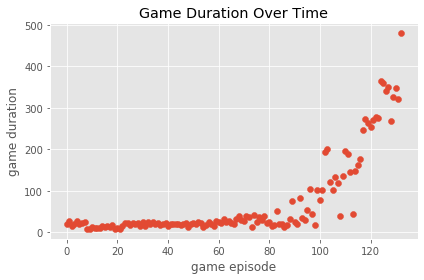

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.scatter(range(i_episode), game_durations)
plt.title('Game Duration Over Time')
plt.xlabel('game episode')
plt.ylabel('game duration')
plt.tight_layout()